#Projet 7 - Implémentez un modèle de scoring
##Partie 1: Exploration et pré-traitement

Dans cette toute première partie, j'explore les données, et je les remodèle.

Le data ingeneering ne faisant pas partie des objectifs de ce projet, et sur suggestion de mon mentor, j'ai réutilisé le prétraitement proposé par JSAguiar, disponible à https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

In [ ]:
import numpy as np
import pandas as pd
import gc
import statistics
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
fichiers = {'application_train': '1ztATz_aYN-OzM-L04kf-J2KL9iUfMj6d',
            'bureau': '1vJ3wanmGazfIwTXYOxeT_WXckh-TGPGw',
            'bureau_balance': '16dQUV31OGGpH1N8jmfF_bBWICI2b-jhd',
            'previous_application': '1TdsBw8H1Op5RaBg8ubUpaCvGuRTQaDWq',
            'POS_CASH_balance': '1_onAFmByBsxH62IOHk4t58ShiL9xO037',
            'installments_payments': '1szIJDrNrHSAAdtsnH6OiTrILRJb85Vsb',
            'credit_card_balance': '1nPI3GOZYfwsTfmTOqYvH37LCYzROM19j'}

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
for (i, (k, v)) in enumerate(fichiers.items()):
    downloaded = drive.CreateFile({'id':v})   # replace the id with id of file you want to access
    downloaded.GetContentFile(k + '.csv')        # replace the file name with your file

# Analyse exploratoire

Je produis ici des graphs que j'utilise habituellement pour commencer les projets, et ceux que j'utilisera dans la présentation ppt.

In [ ]:
data0 = pd.read_csv('application_train.csv')

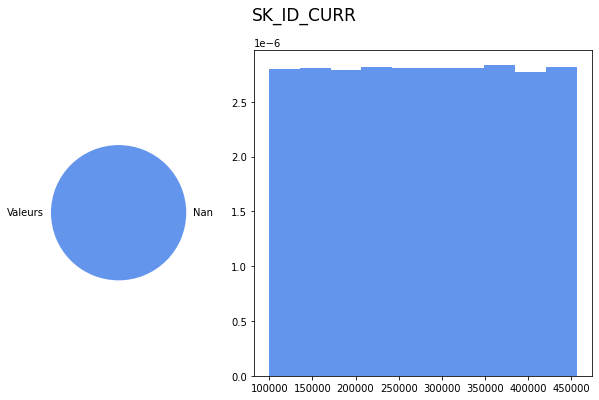

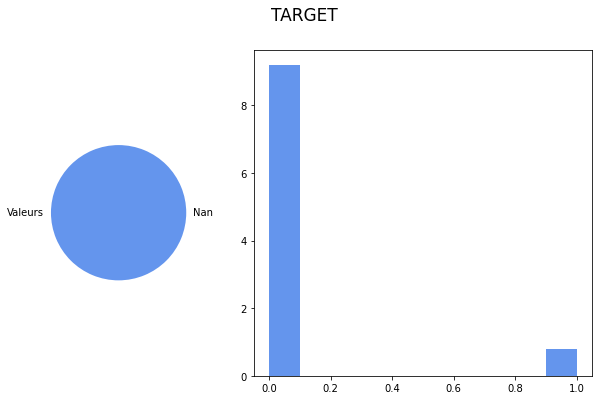

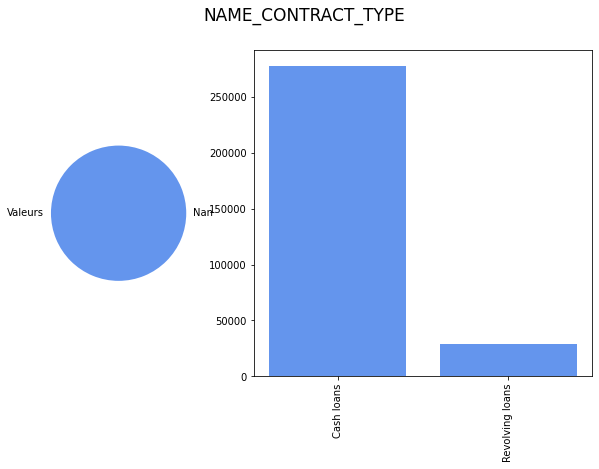

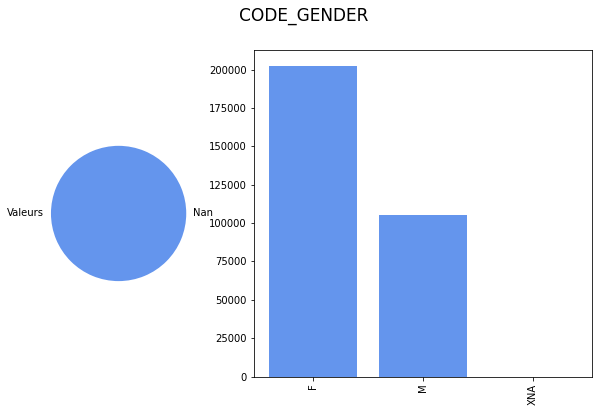

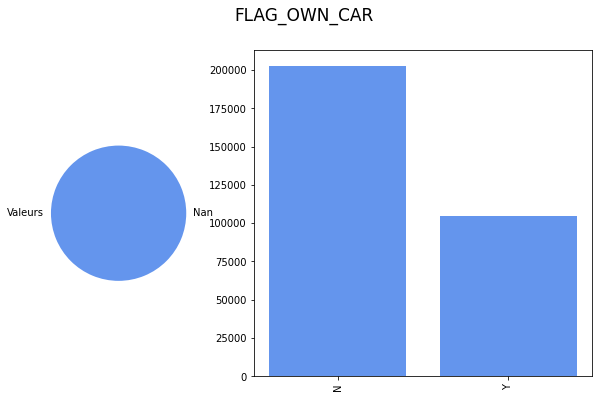

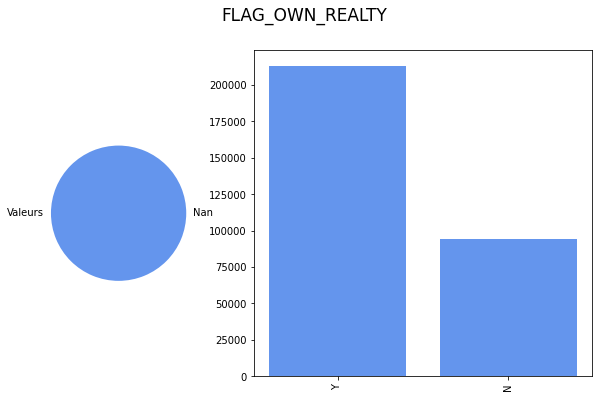

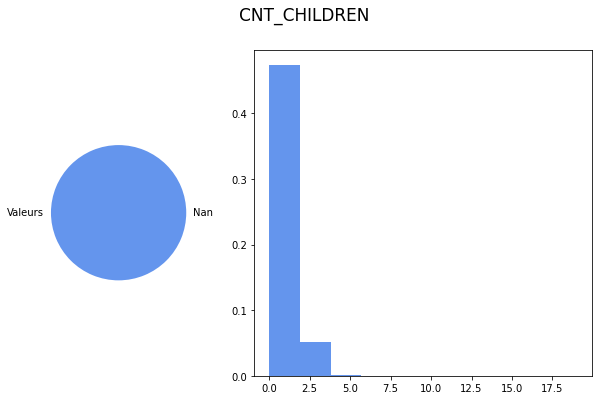

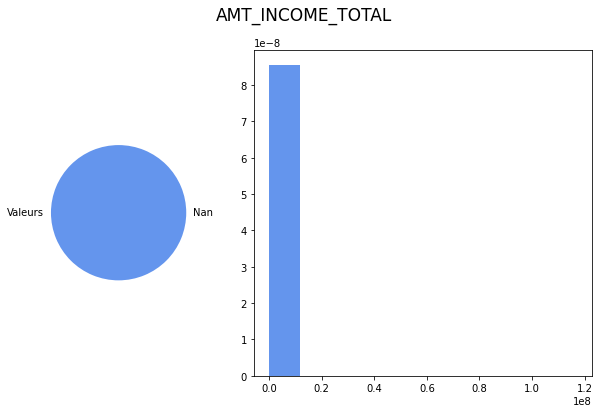

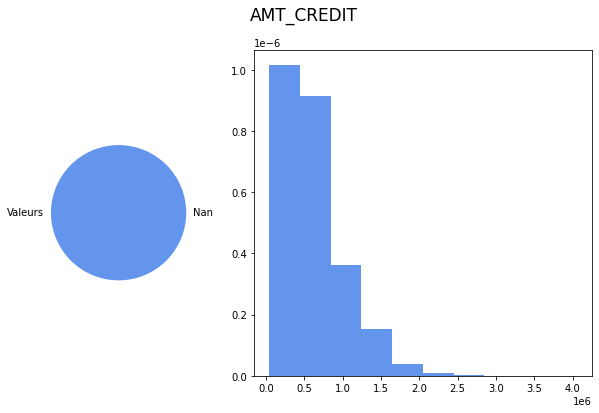

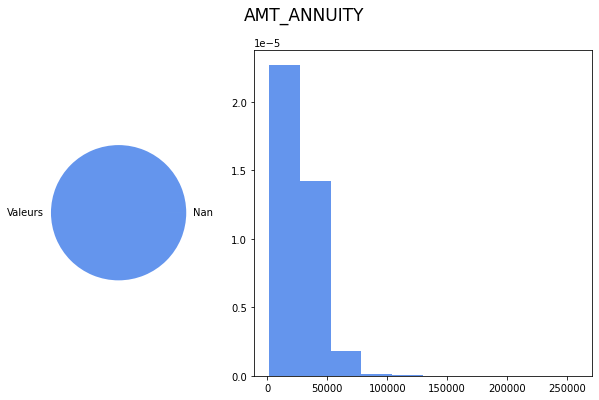

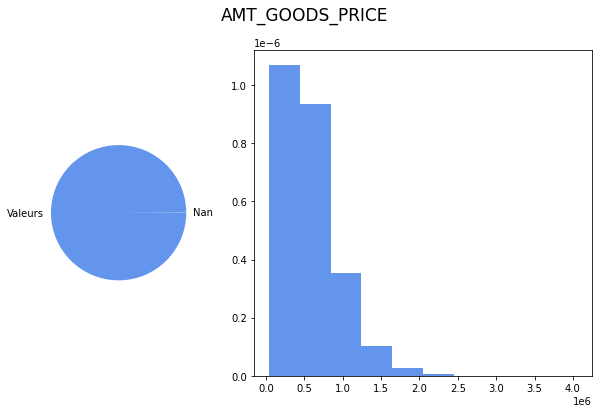

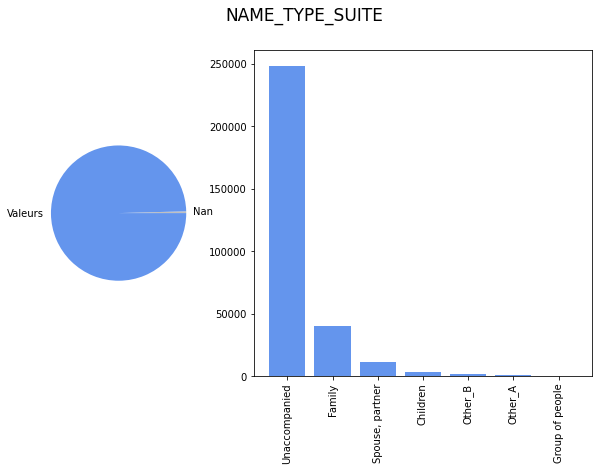

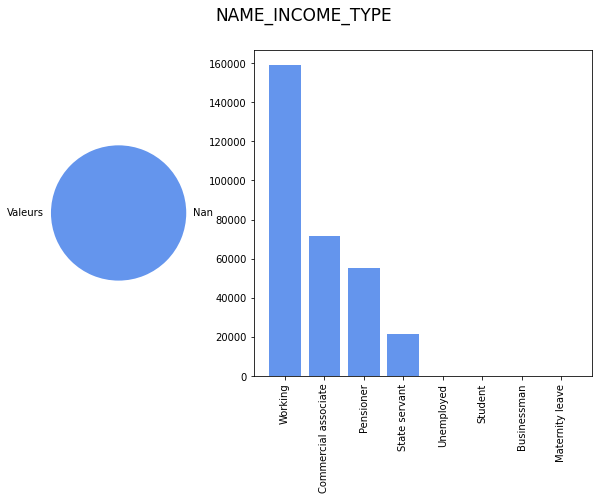

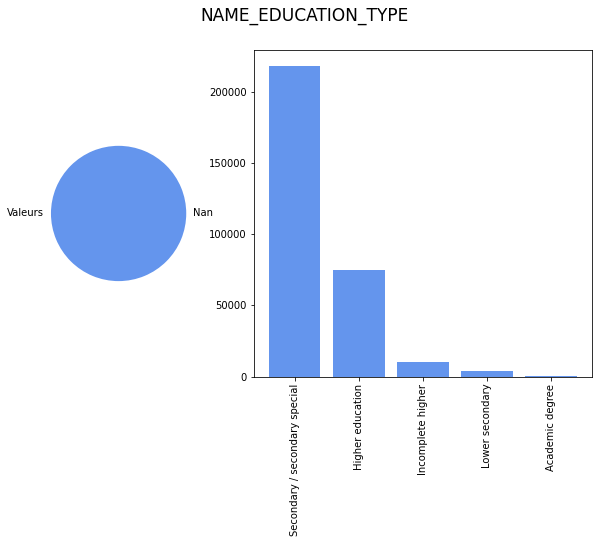

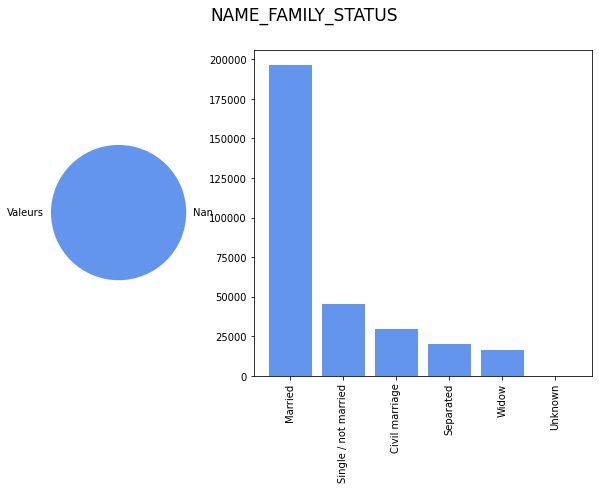

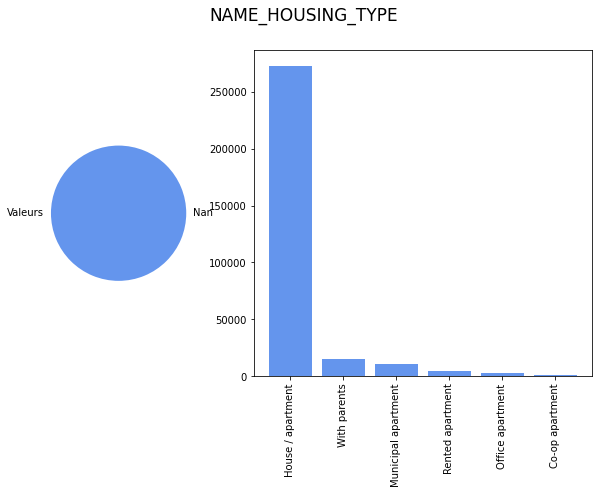

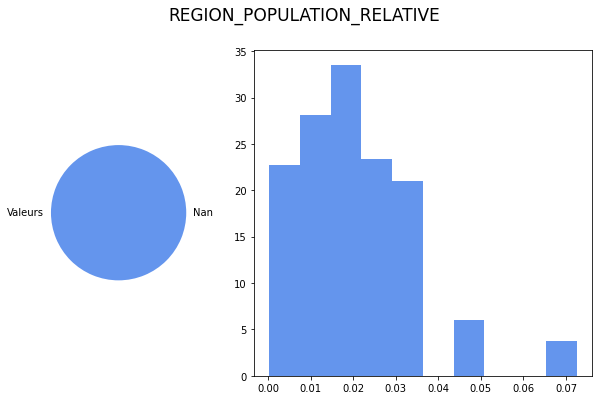

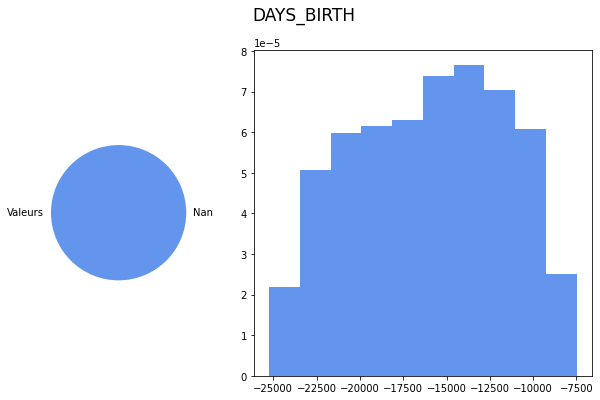

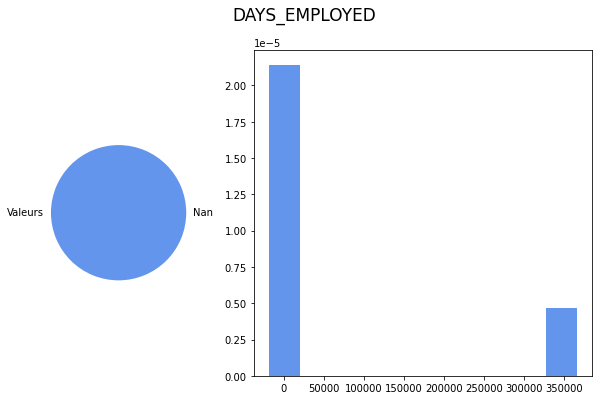

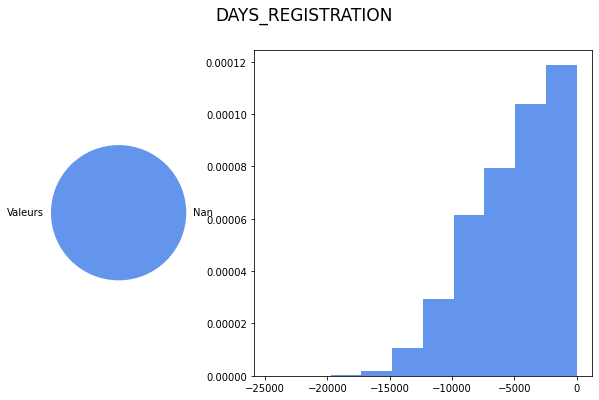

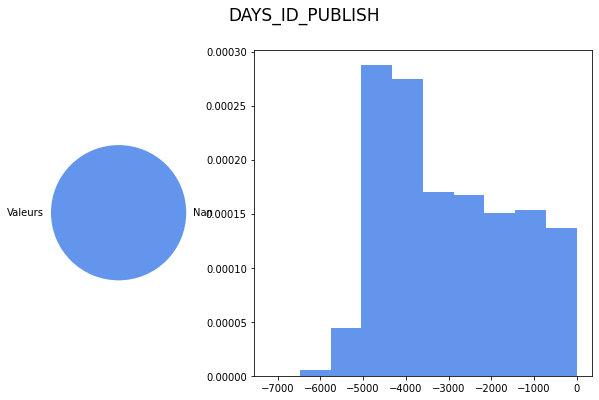

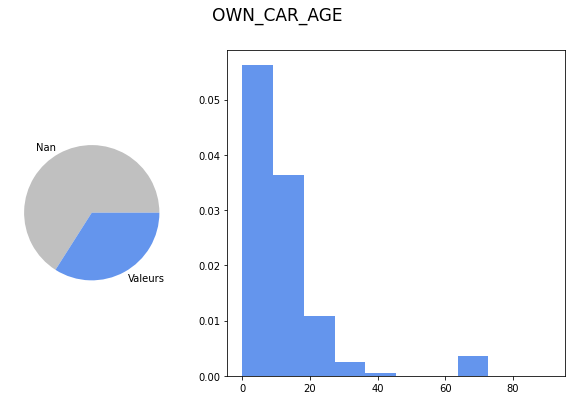

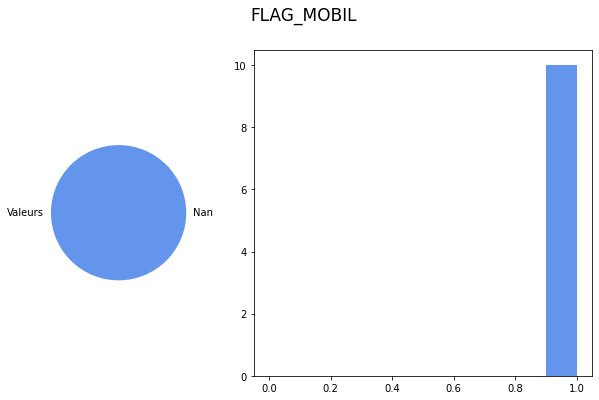

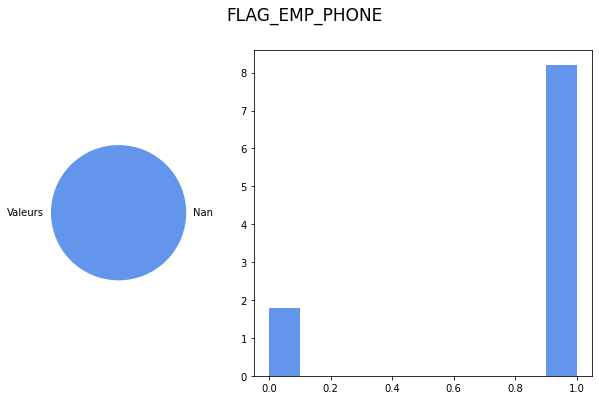

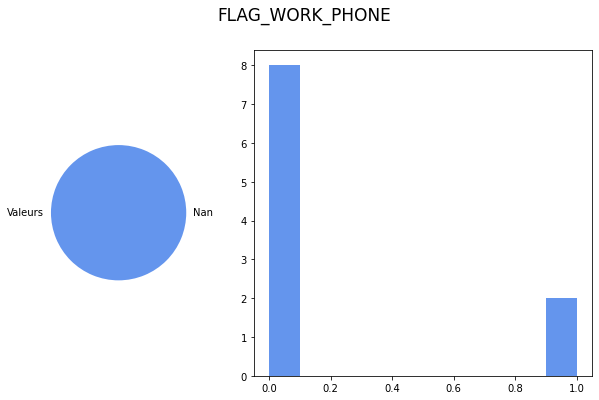

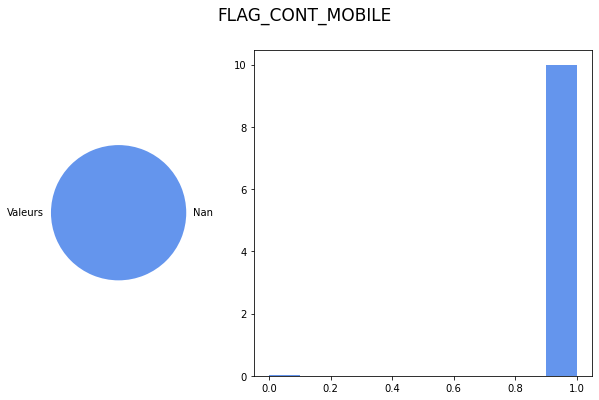

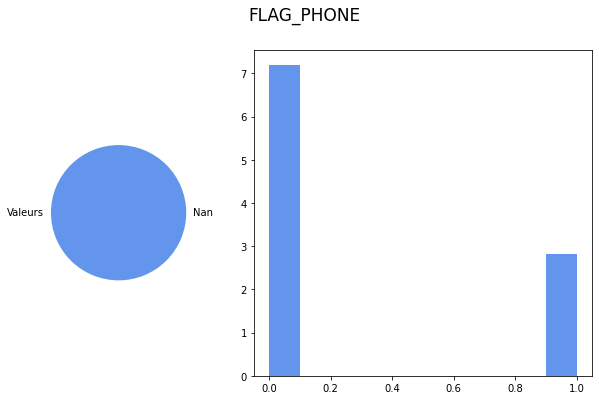

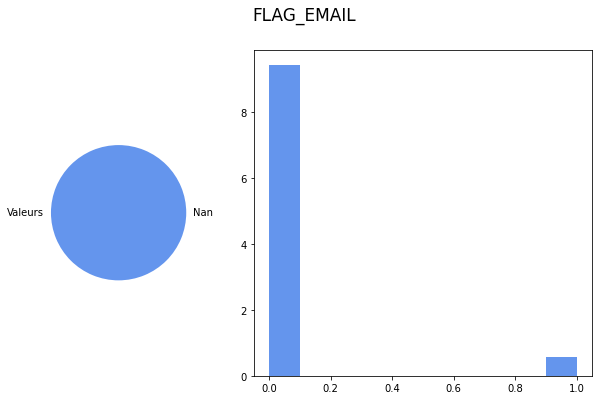

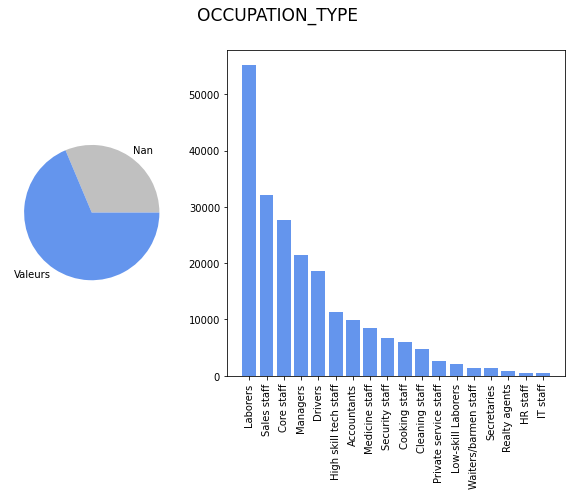

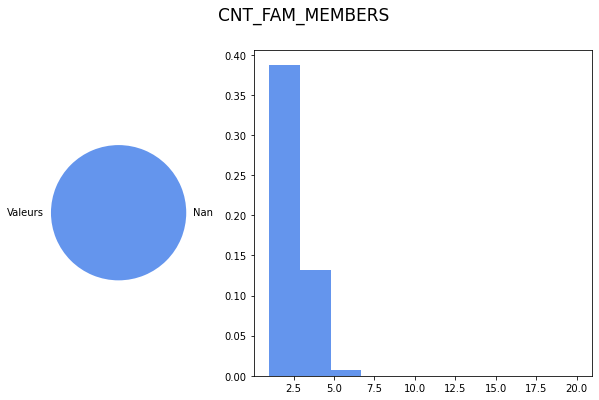

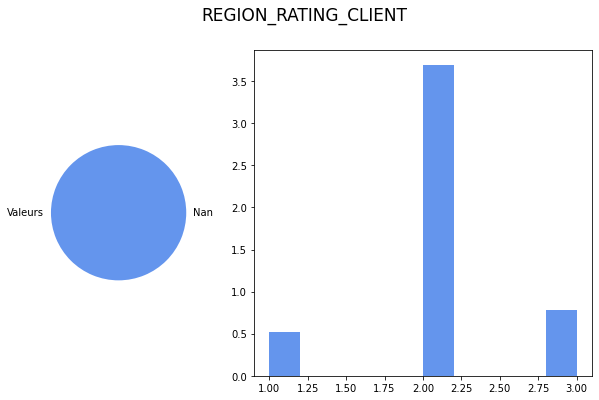

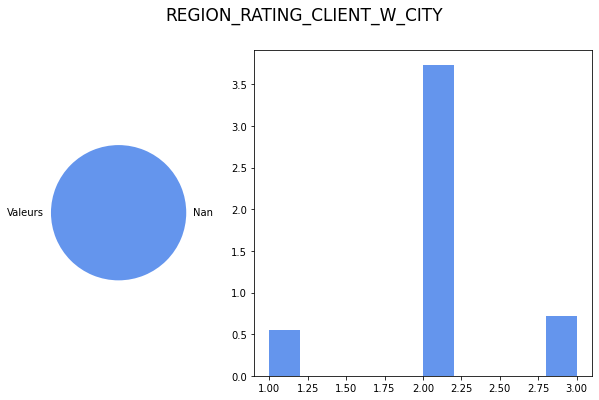

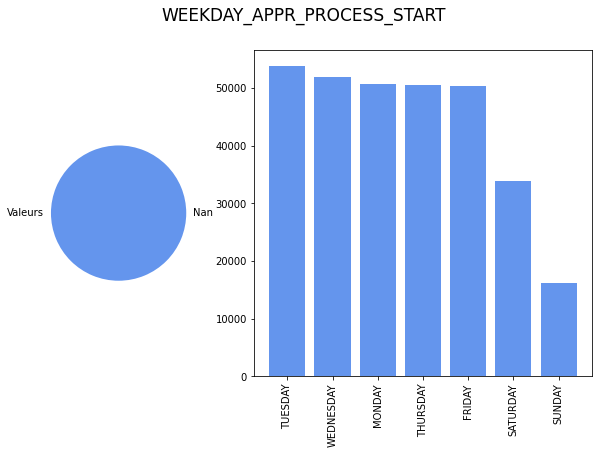

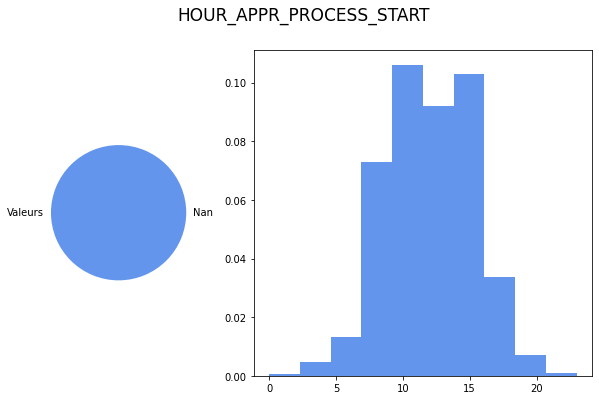

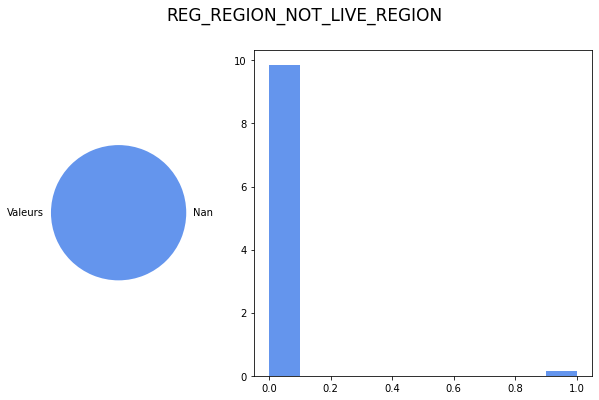

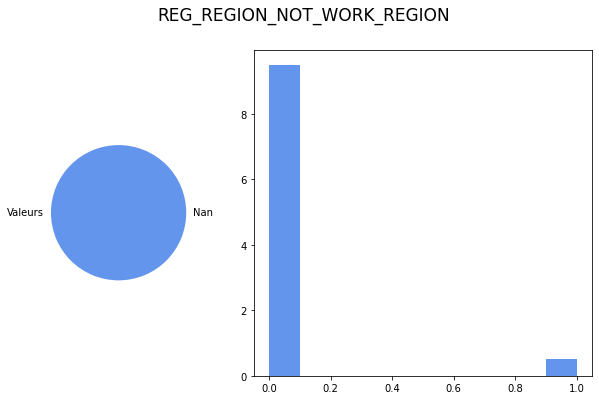

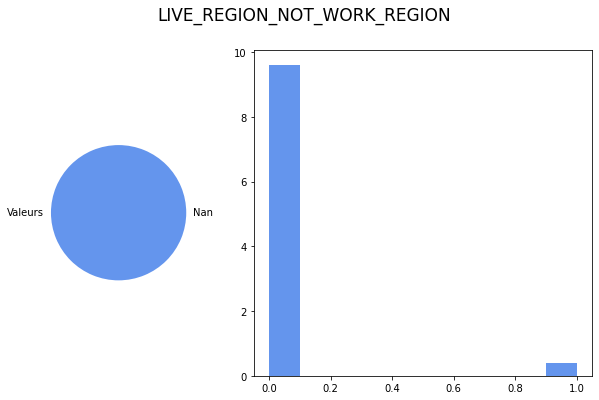

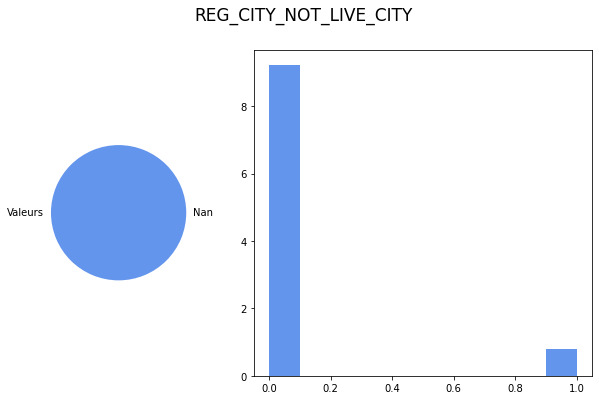

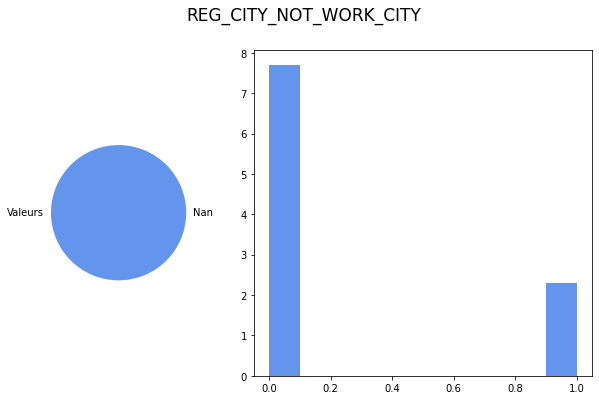

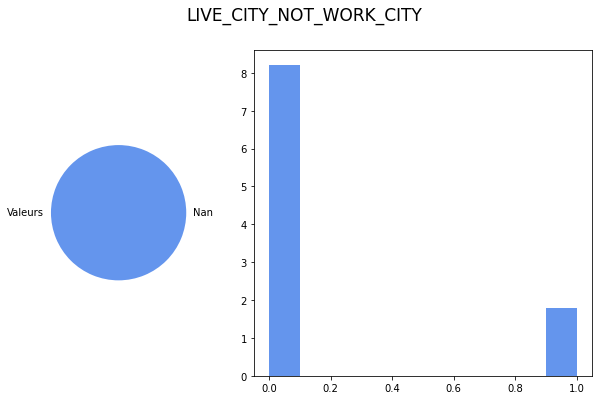

Not shown: ORGANIZATION_TYPE


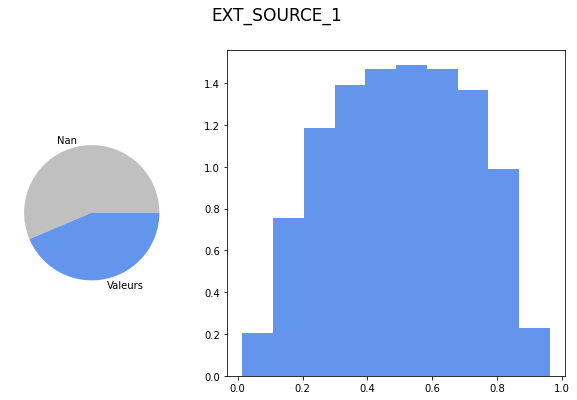

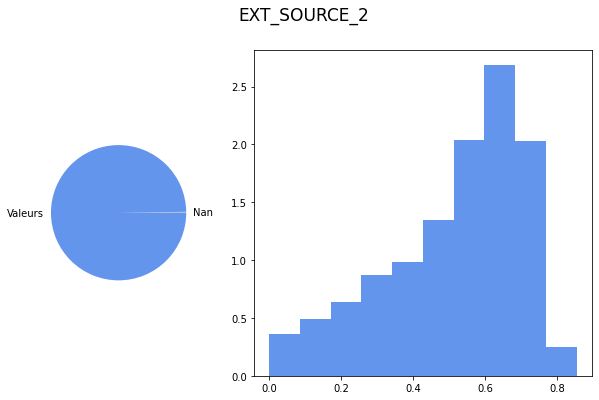

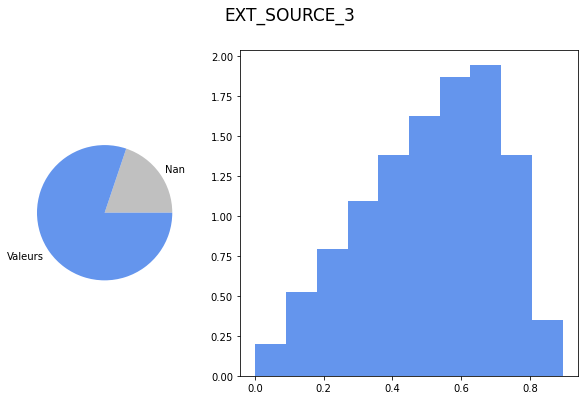

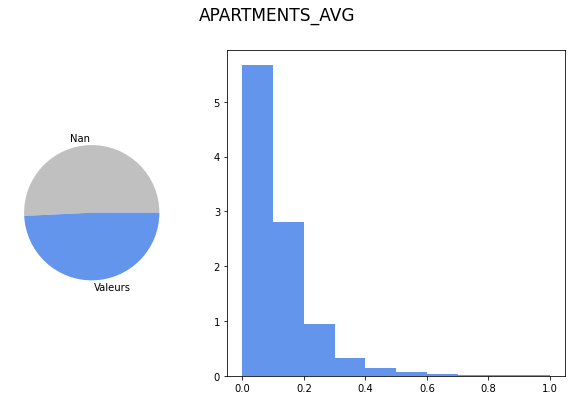

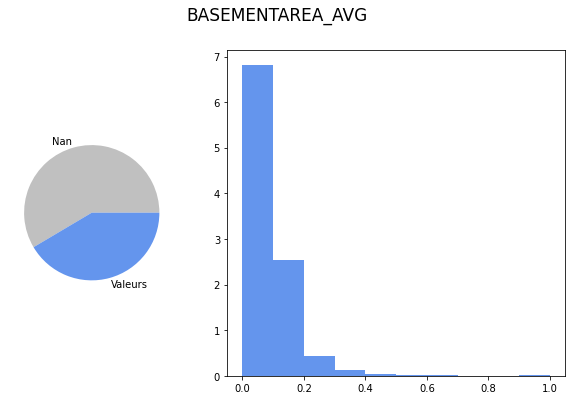

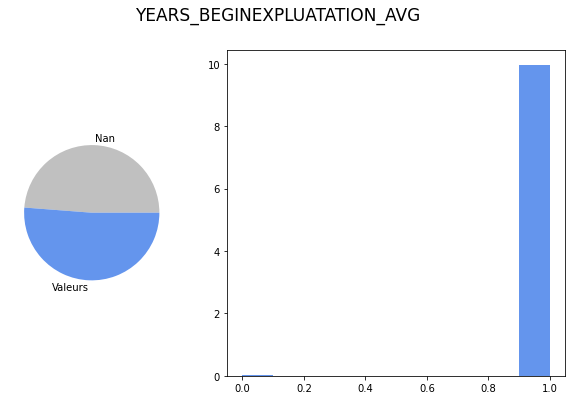

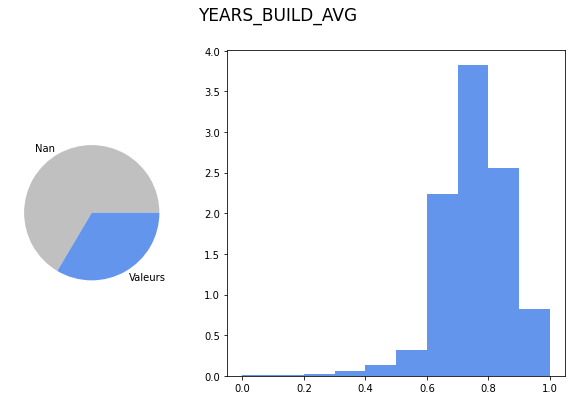

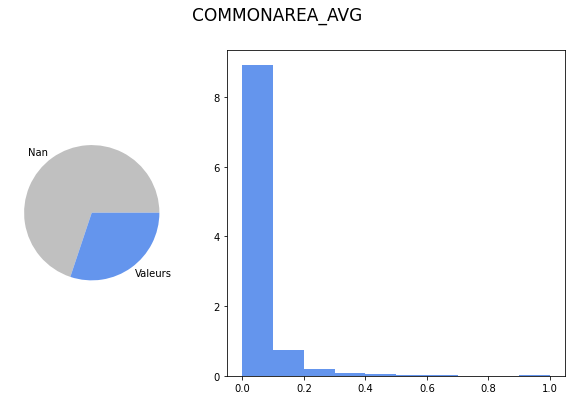

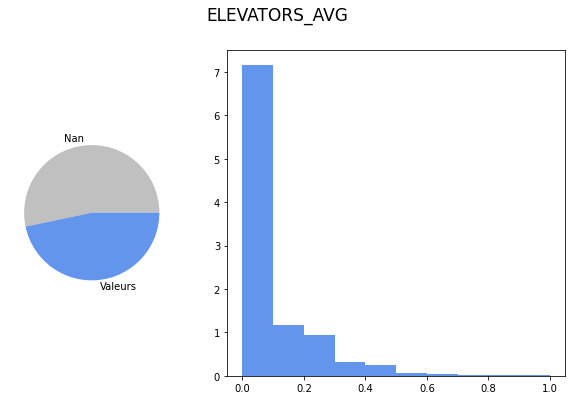

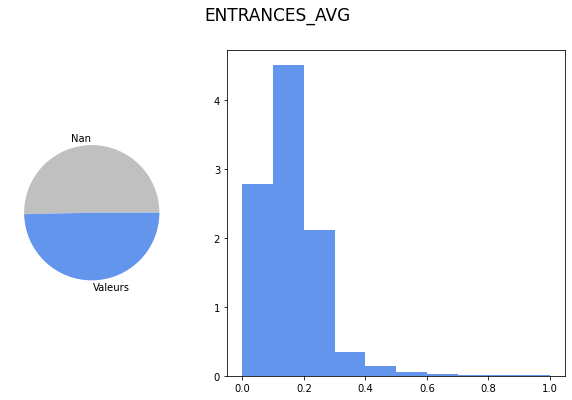

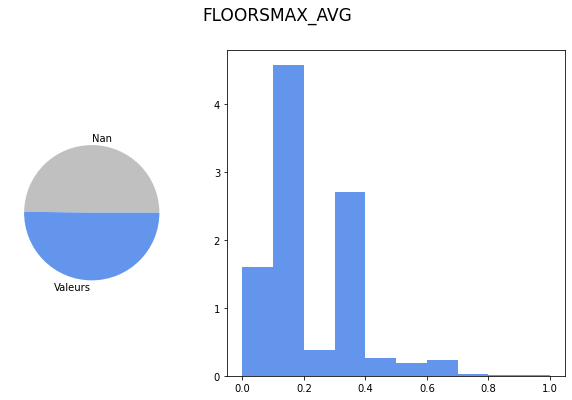

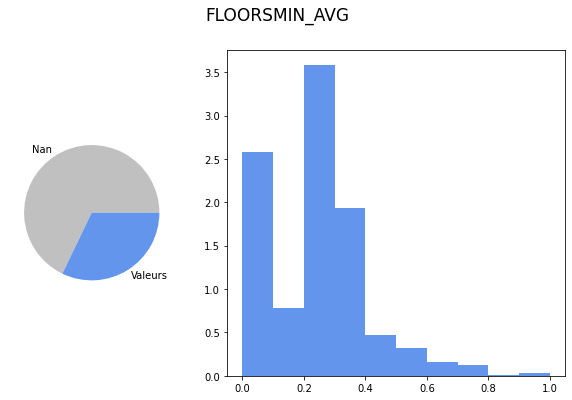

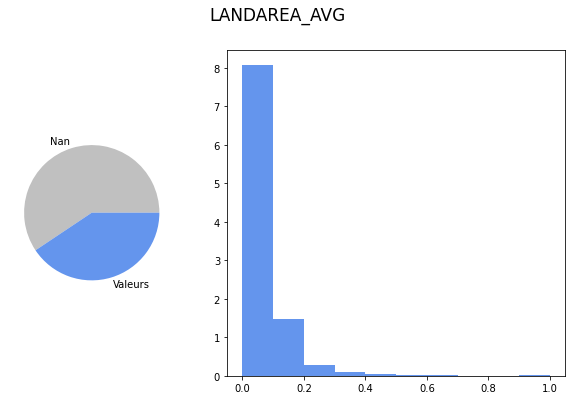

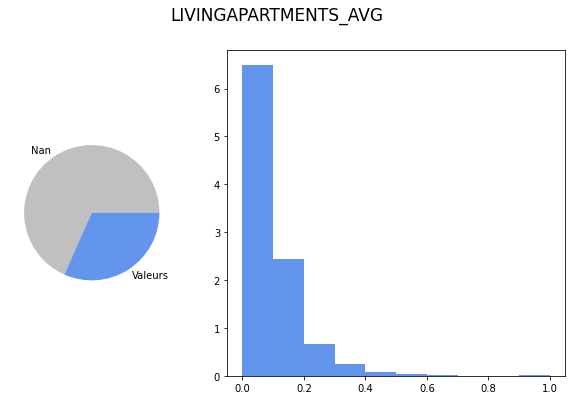

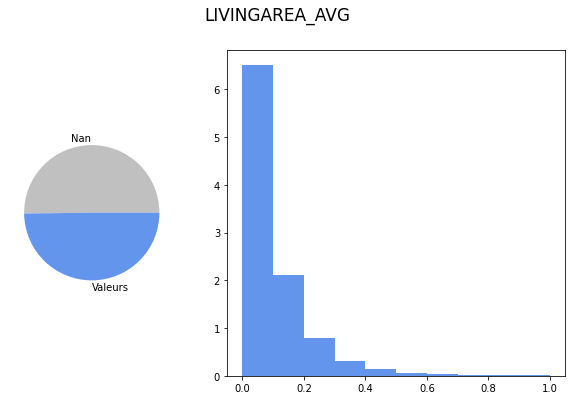

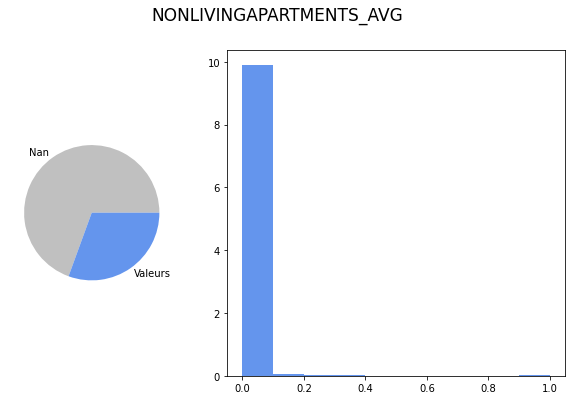

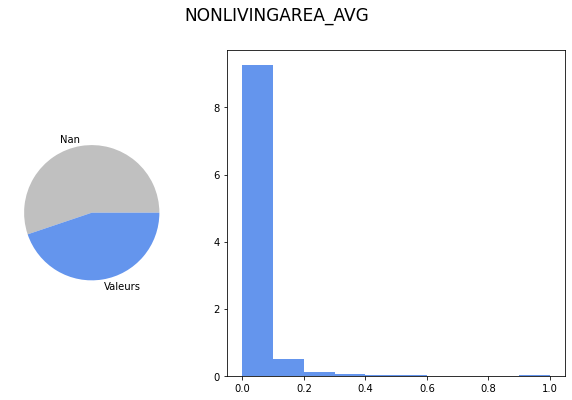

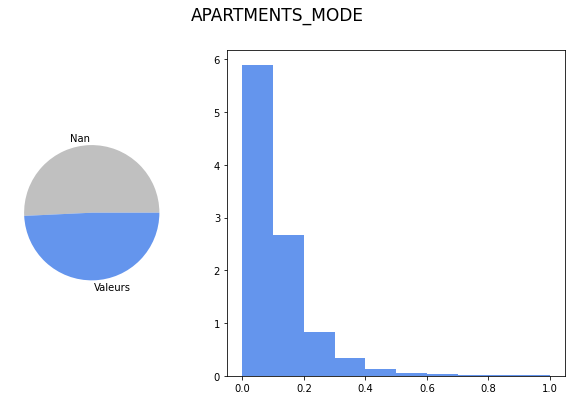

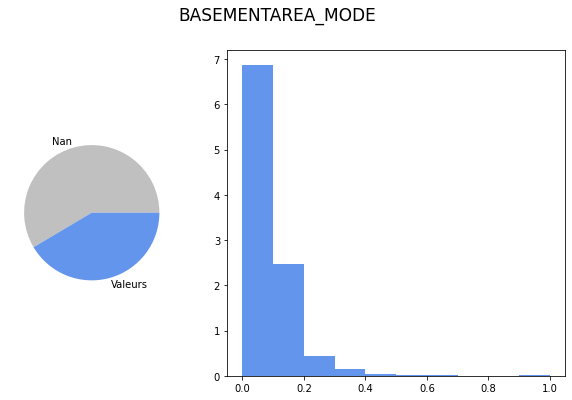

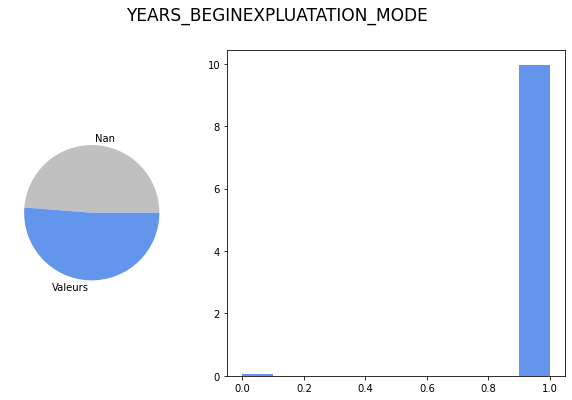

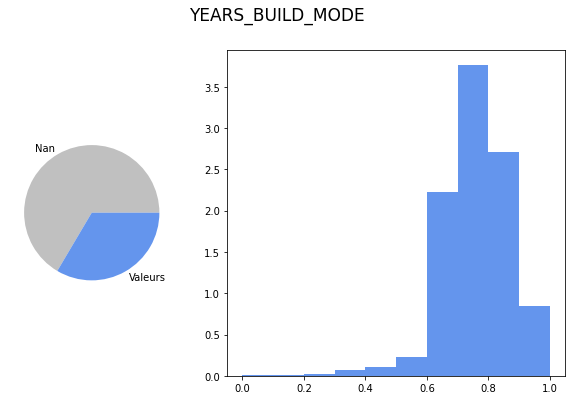

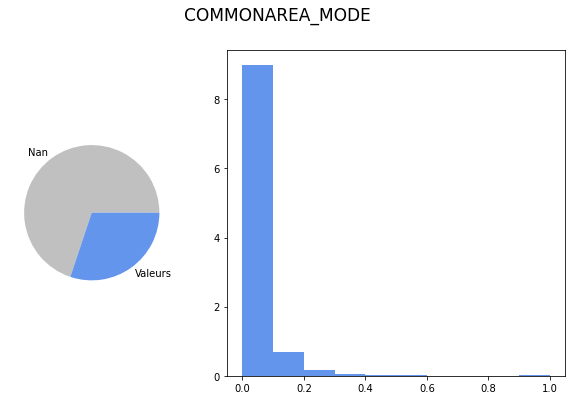

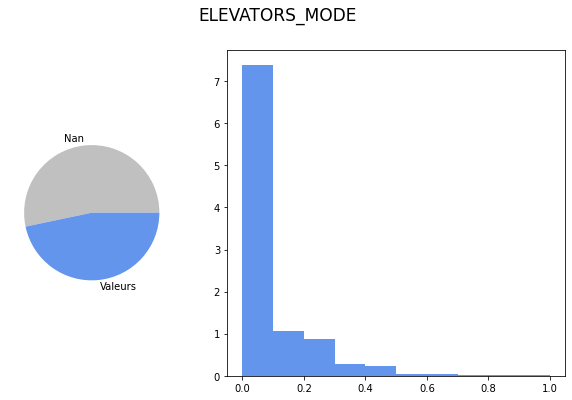

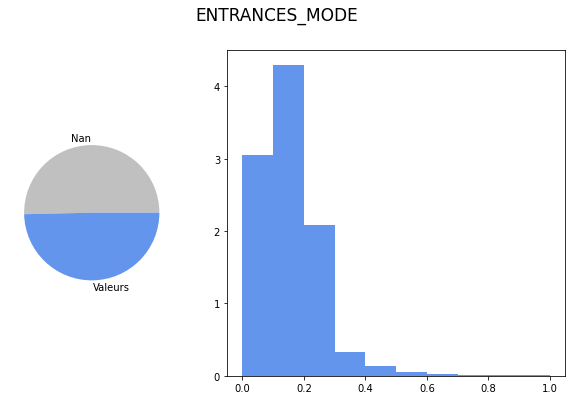

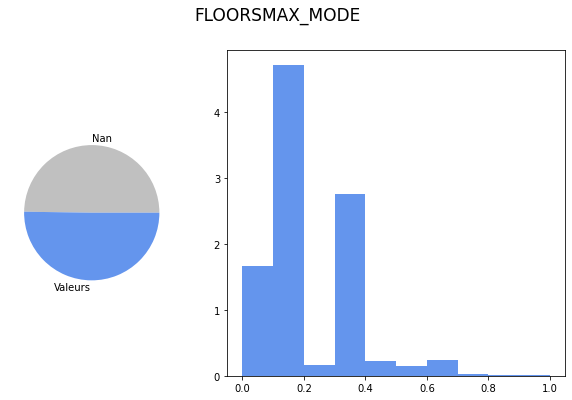

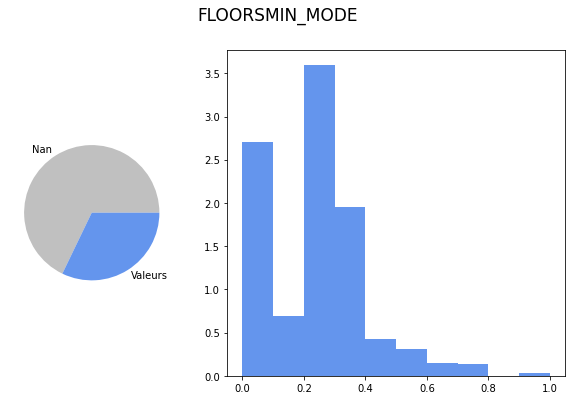

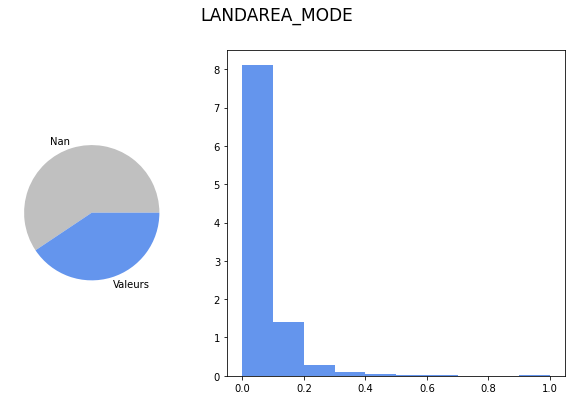

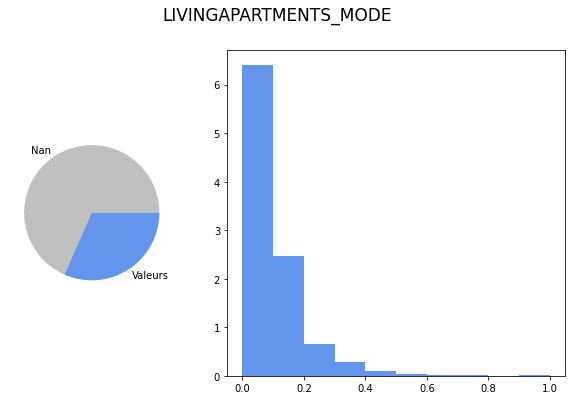

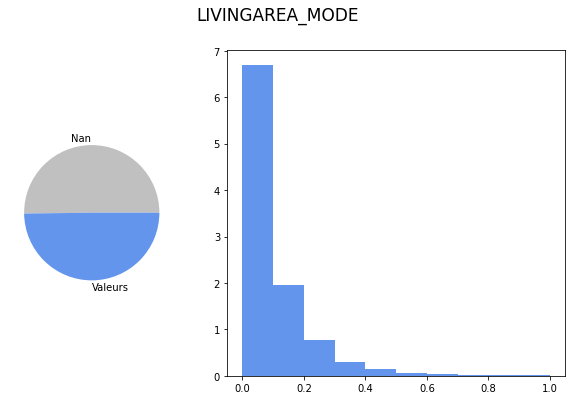

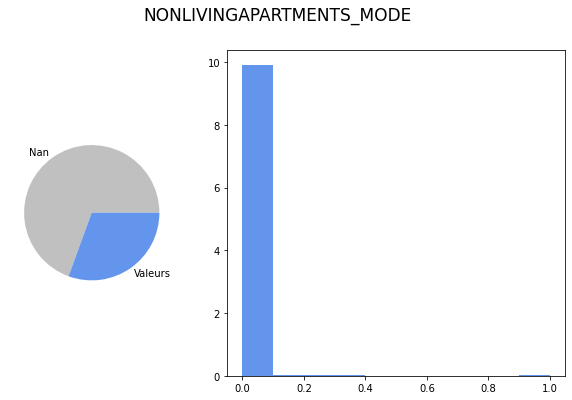

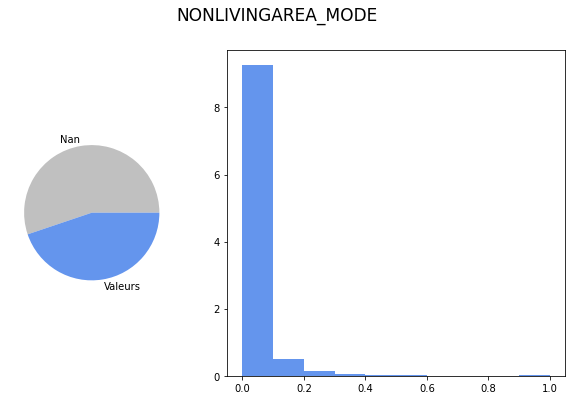

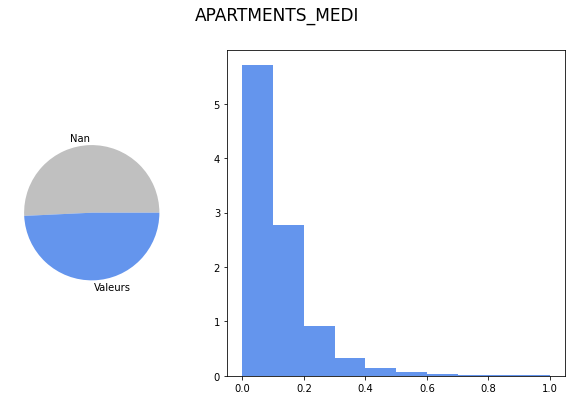

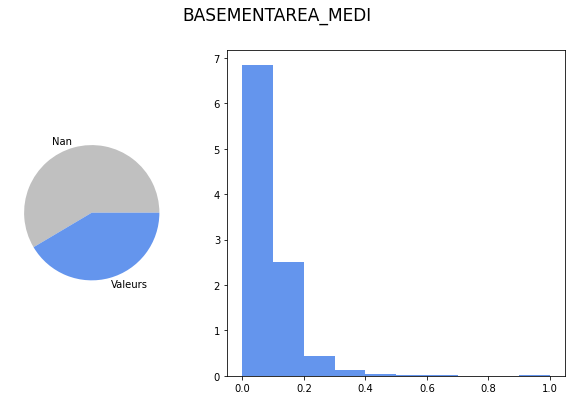

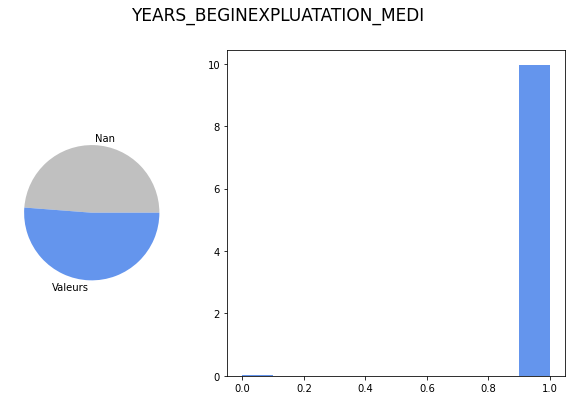

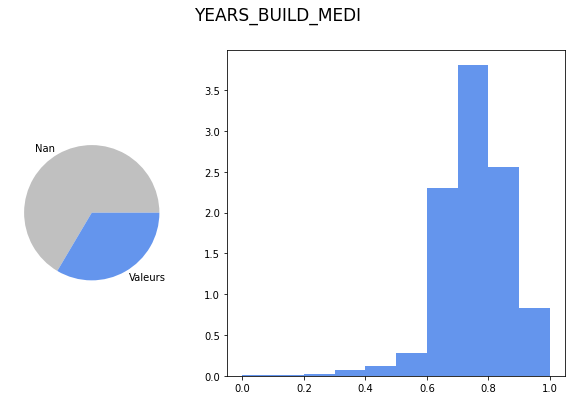

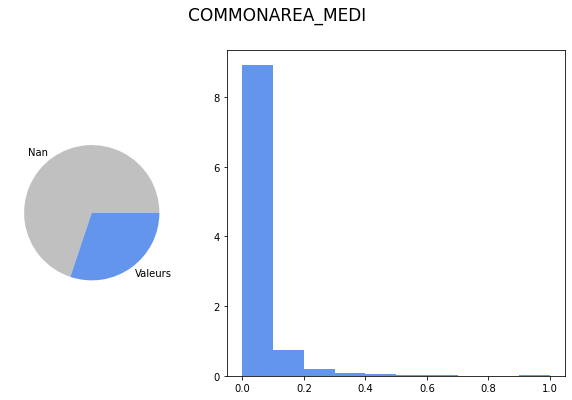

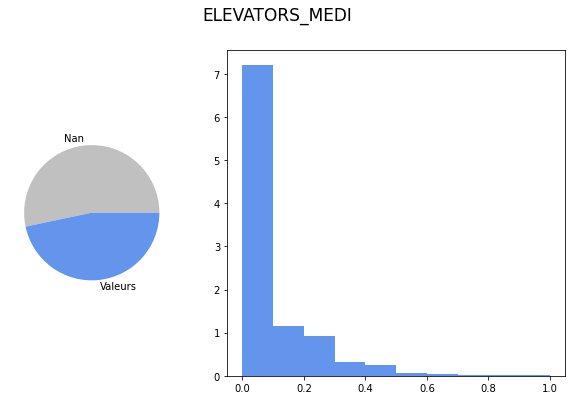

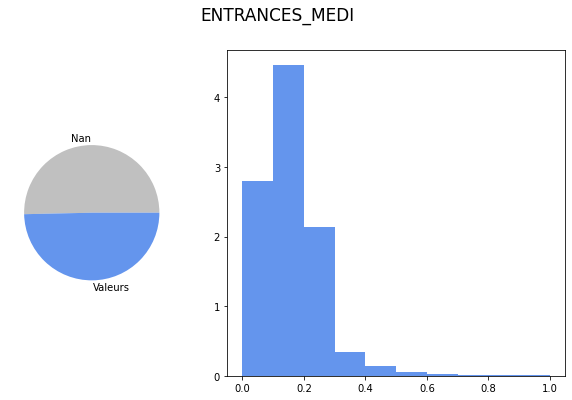

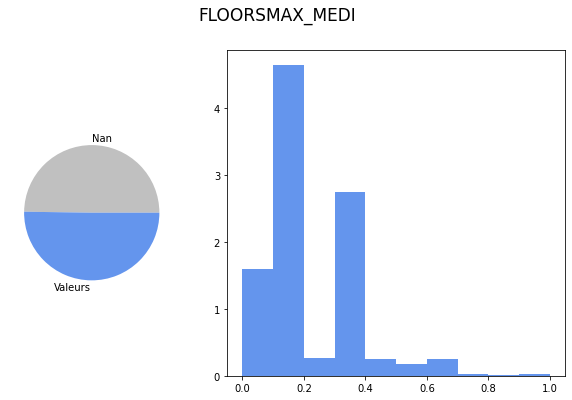

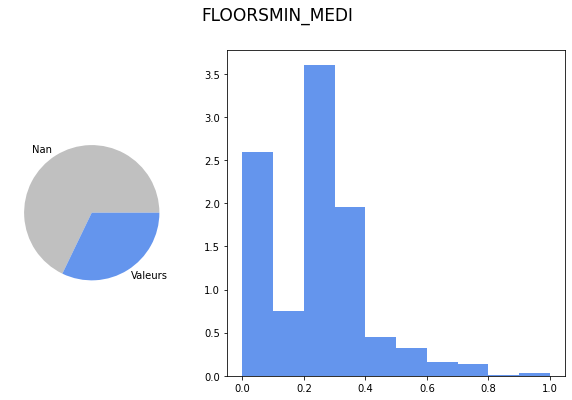

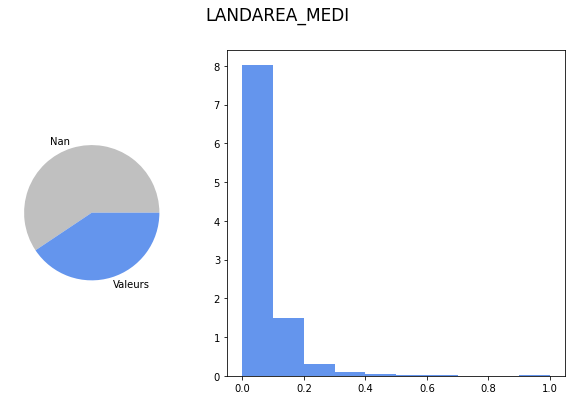

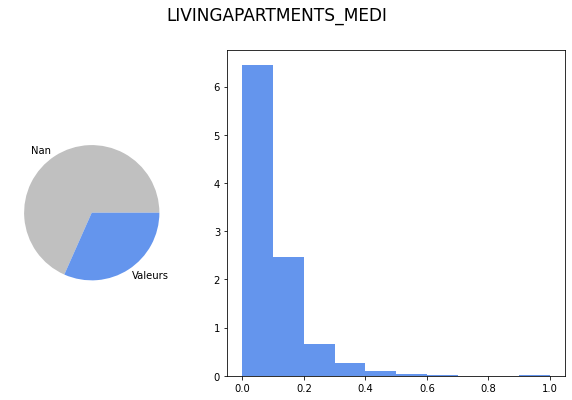

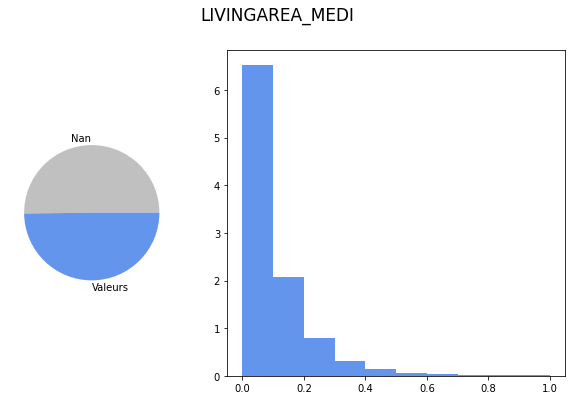

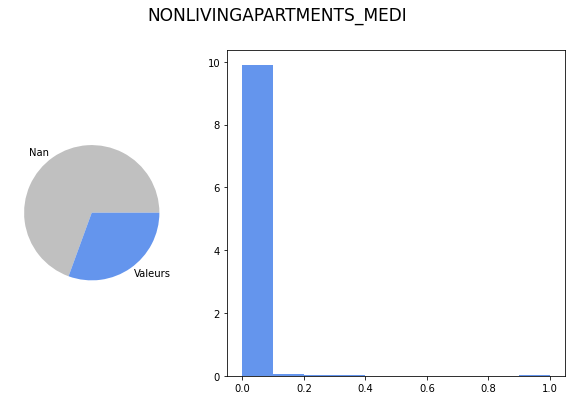

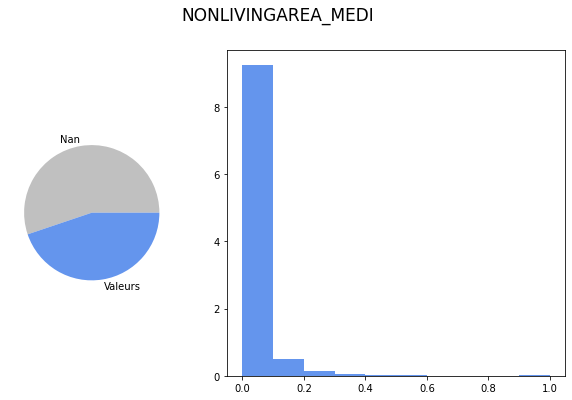

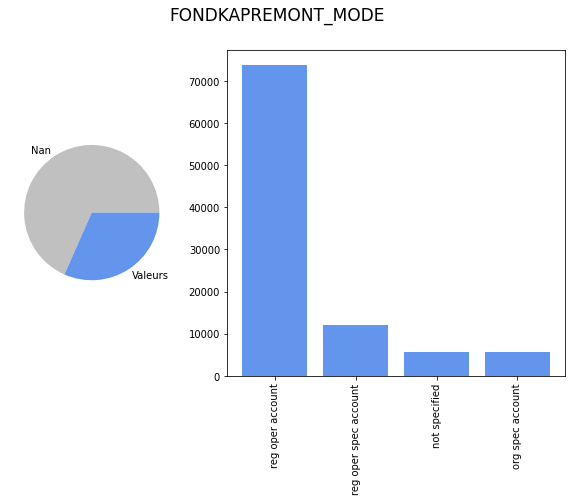

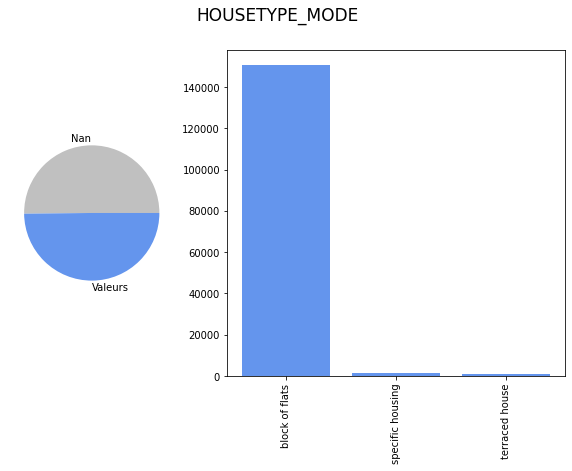

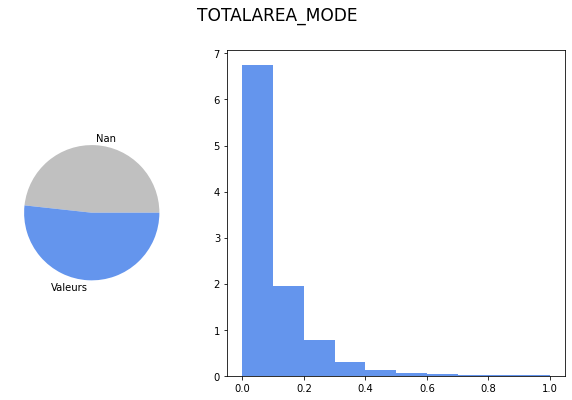

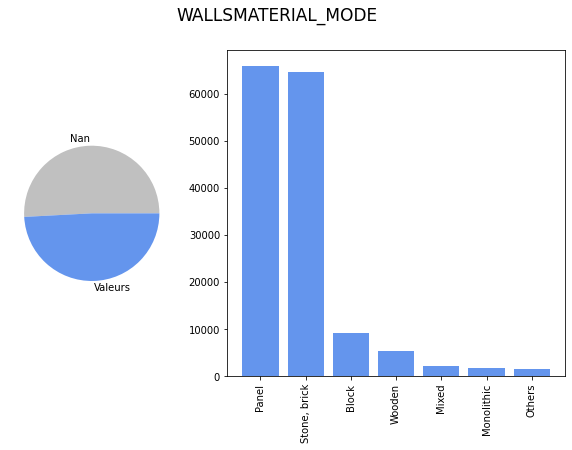

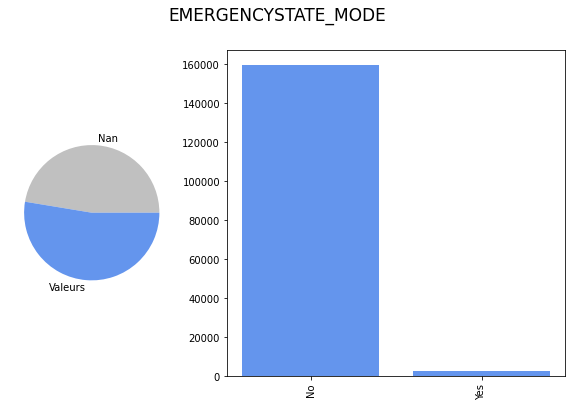

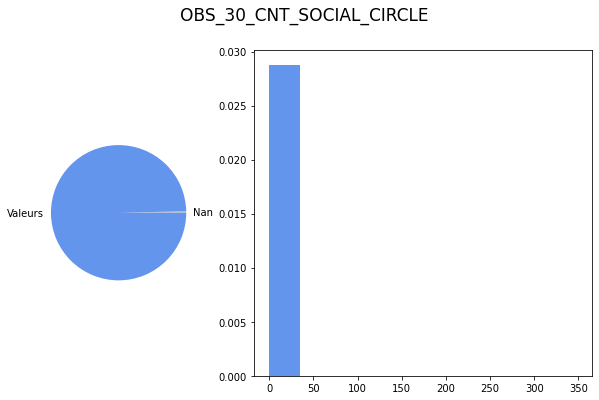

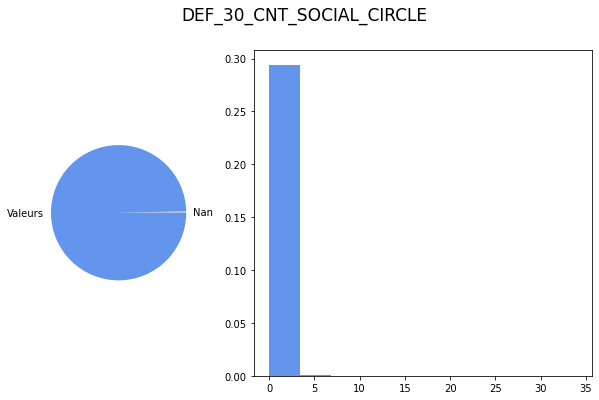

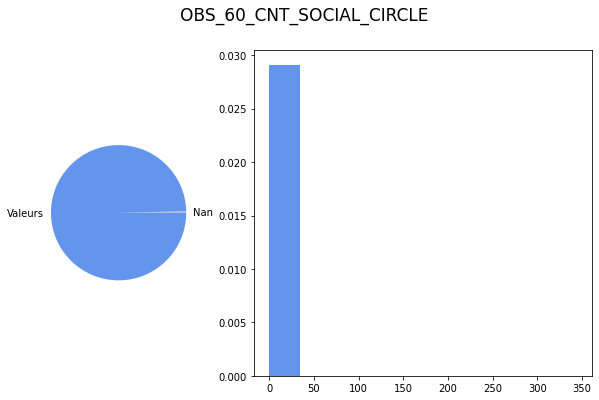

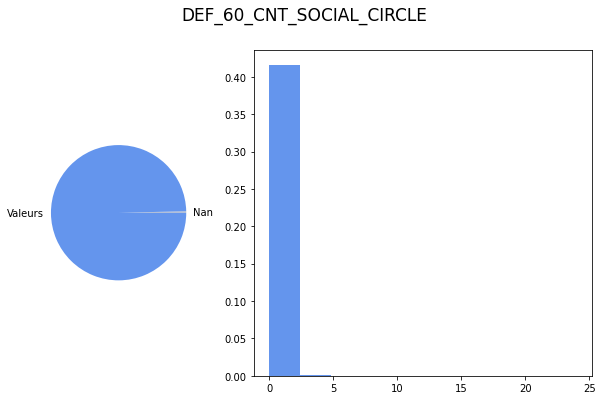

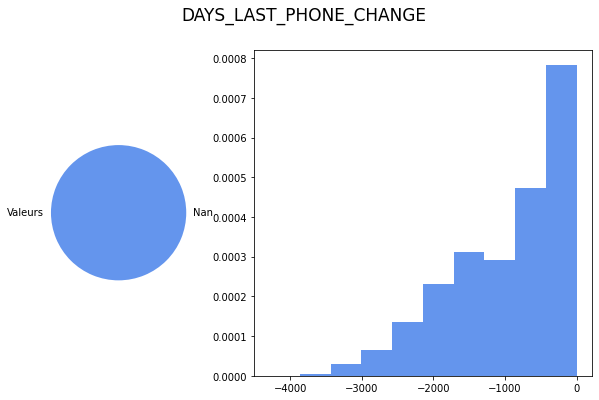

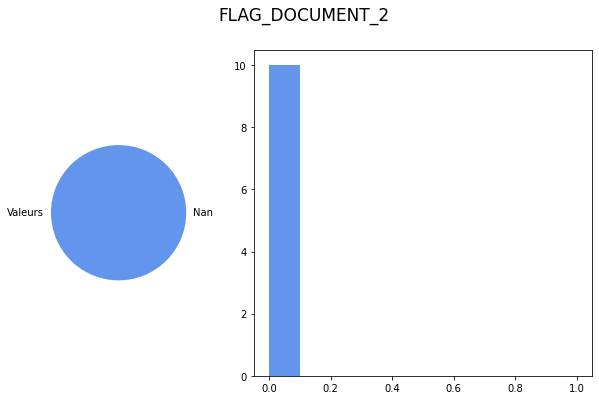

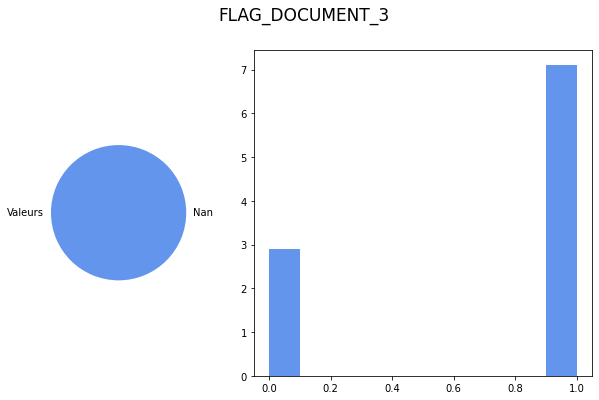

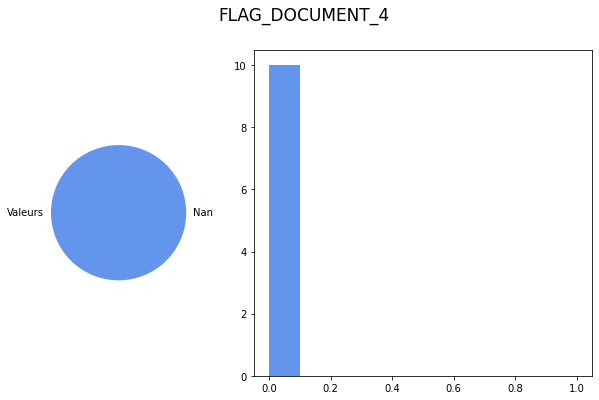

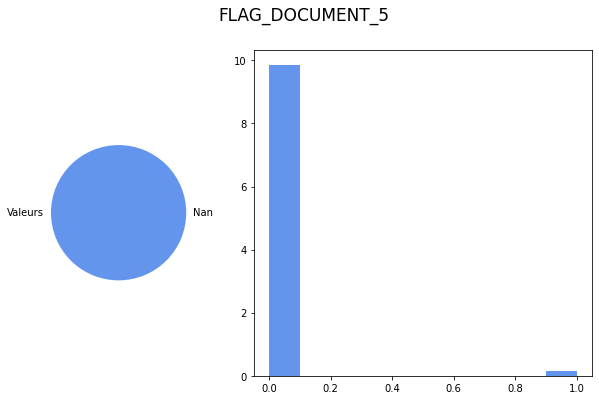

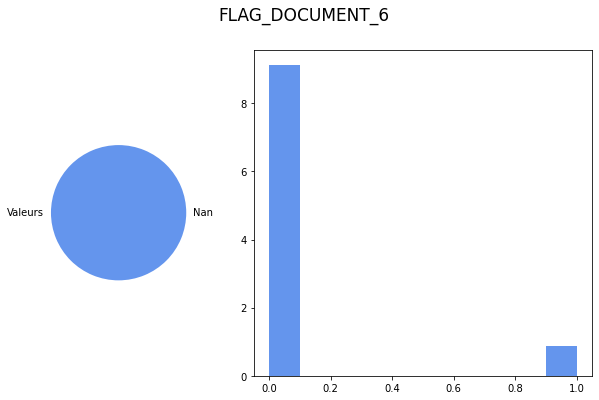

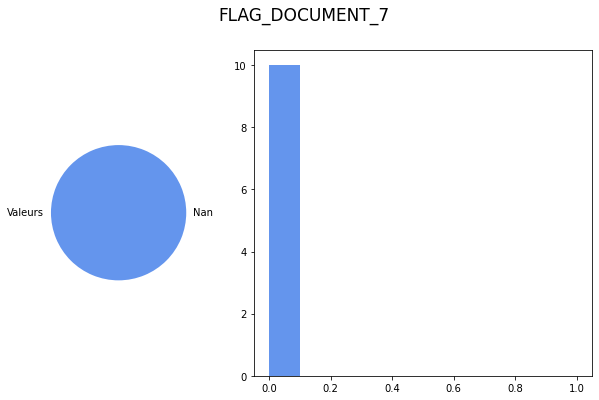

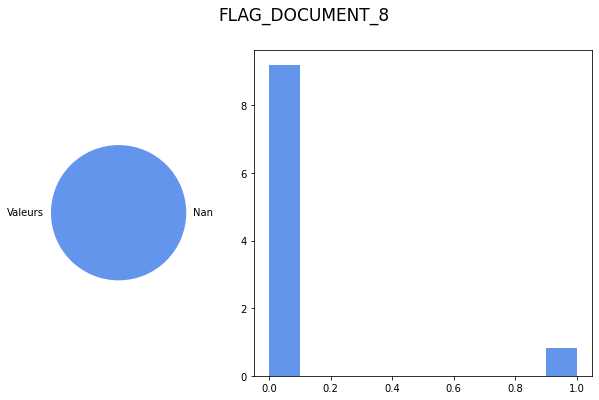

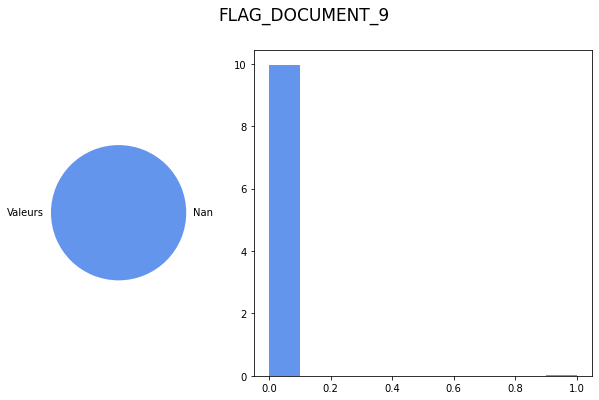

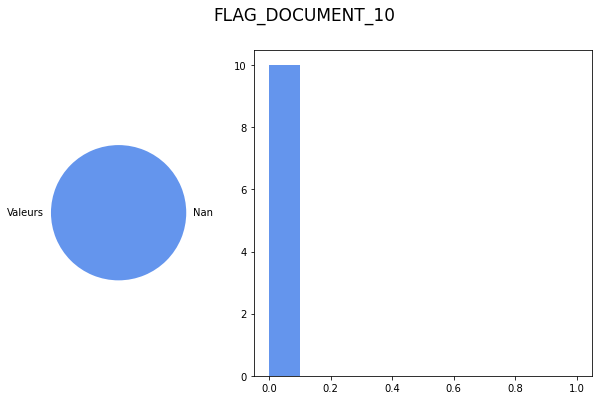

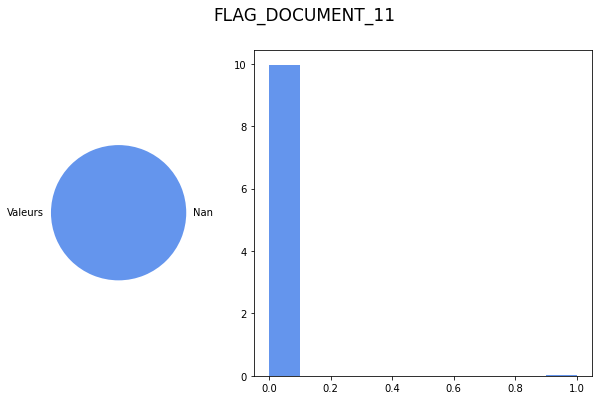

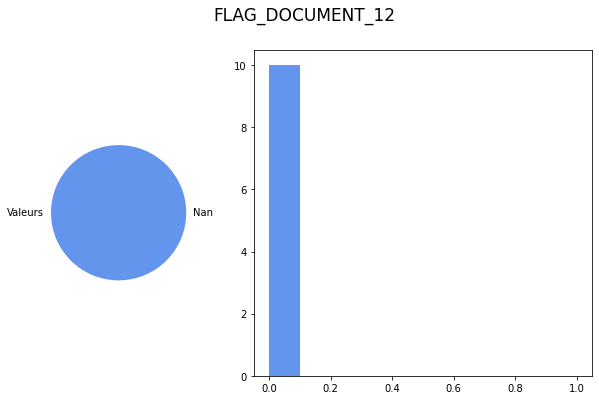

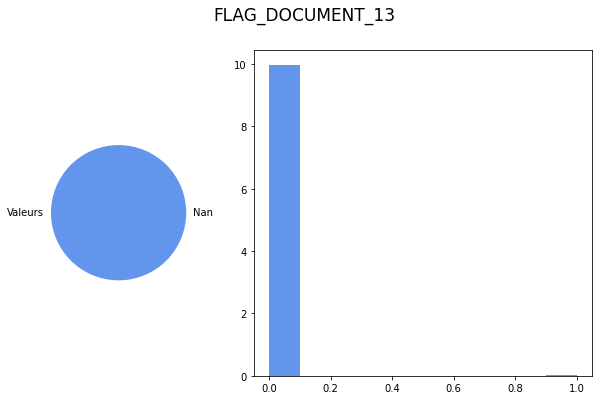

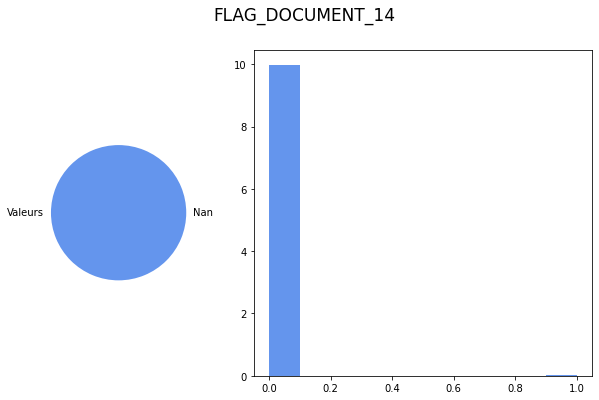

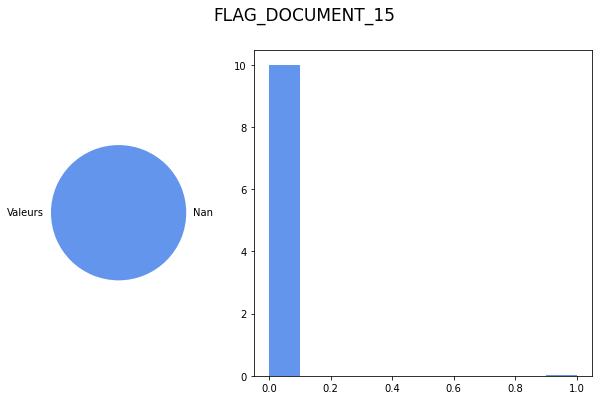

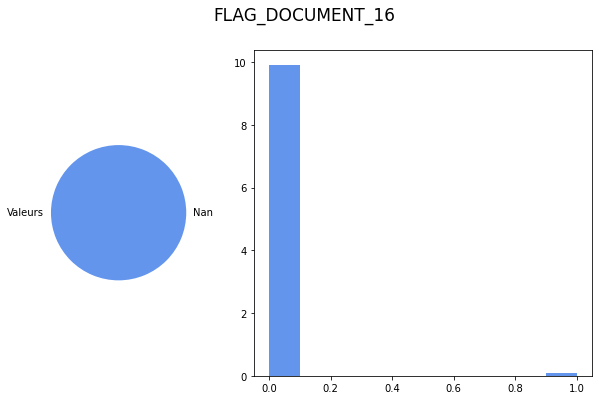

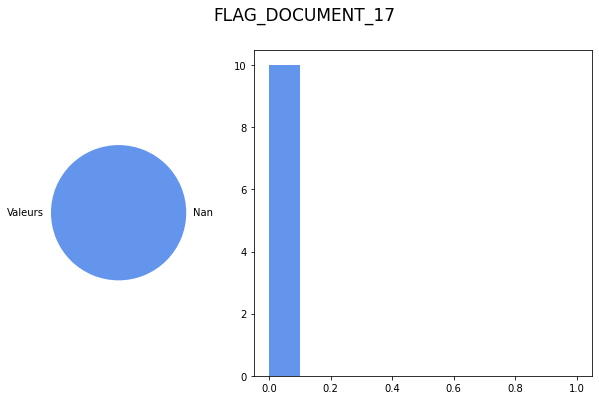

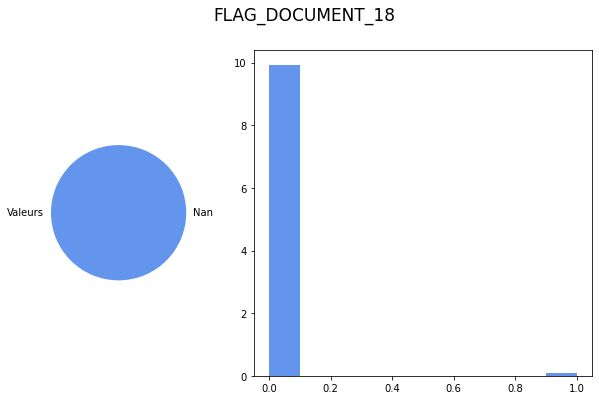

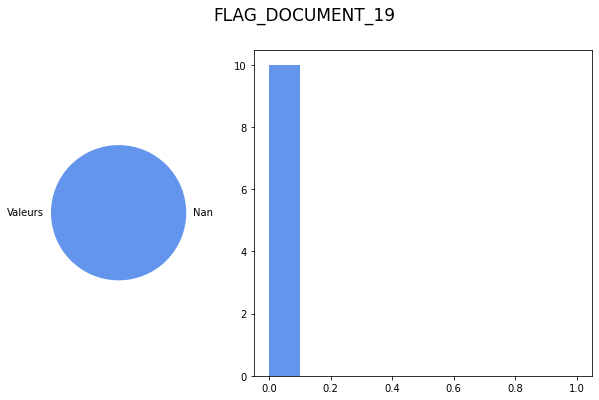

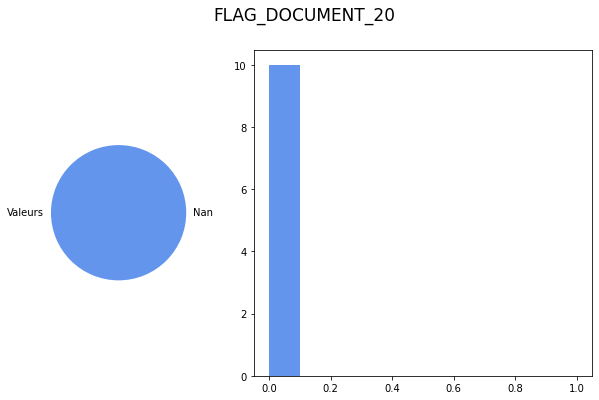

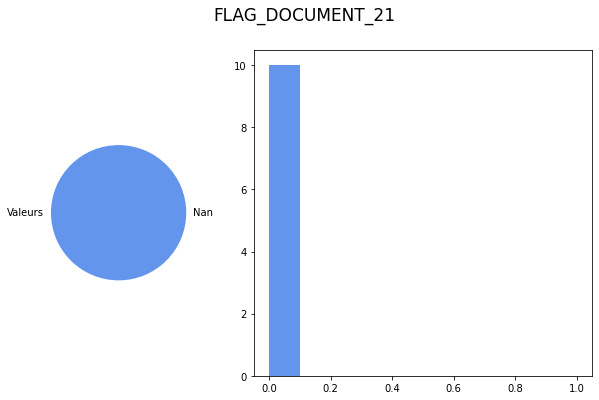

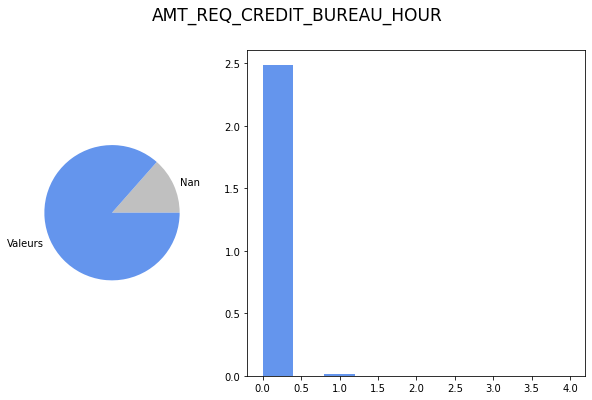

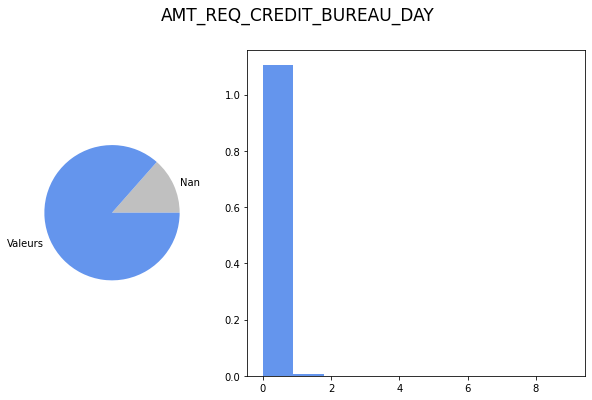

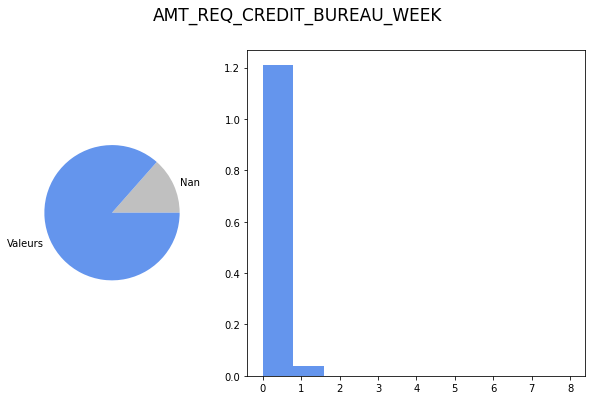

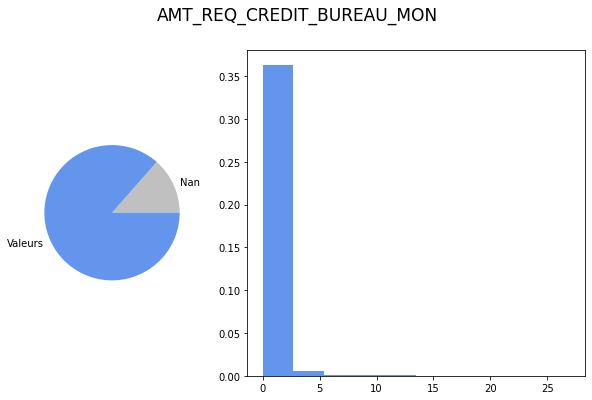

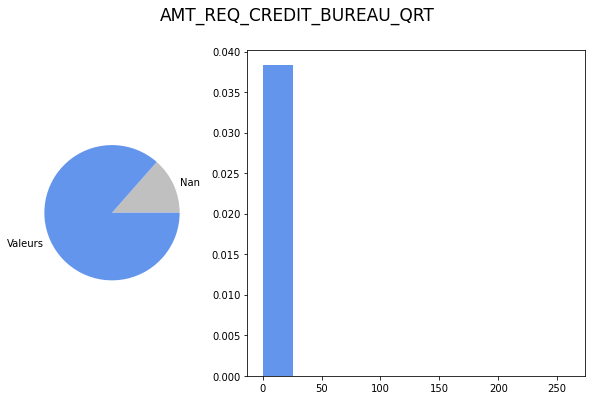

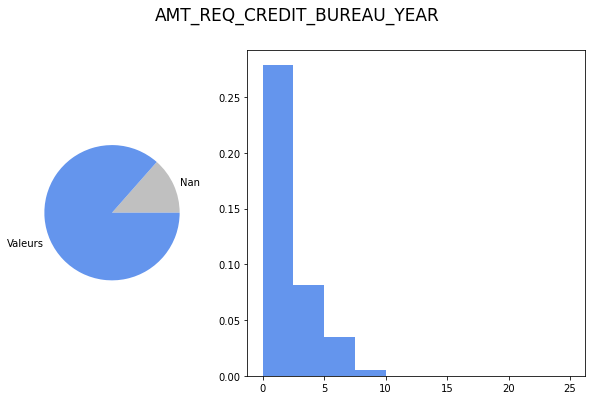

 
ORGANIZATION_TYPE:
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal'] et 28 autres.


In [ ]:
Not_shown = []
for i in data0.columns.tolist():
    if all(isinstance(e, (int, float, np.int64, np.int32)) for e in data0[i].unique()):
        val_na = data0[i].isna().sum()/len(data0[i])
        val_non_na = 1 - val_na
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(10,6))
        fig.suptitle(i, fontsize=17)
        ax1.pie([val_na, val_non_na], labels = ['Nan', 'Valeurs'], colors=['silver', 'cornflowerblue'])
        ax2.hist(data0[i], density=True, color=['cornflowerblue'])
        plt.show()        
    else:
        if len(data0[i].unique()) < 30:
            nombre_vals = data0[i].value_counts()
            val_na = data0[i].isna().sum()/len(data0[i])
            val_non_na = 1 - val_na
            fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(10,6))
            fig.suptitle(i, fontsize=17)
            ax1.pie([val_na, val_non_na], labels = ['Nan', 'Valeurs'], colors=['silver', 'cornflowerblue'])
            ax2.bar(nombre_vals.index, nombre_vals.values, color=['cornflowerblue'])
            plt.xticks(rotation=90)  
            plt.show()
        else:
            print('Not shown: '+str(i))
            Not_shown.append(i)
for i in Not_shown:
    print(' ')
    print(str(i)+':')
    print(str(data0[i].unique()[0:29])+' et '+str(len(data0[i].unique())-30)+' autres.')

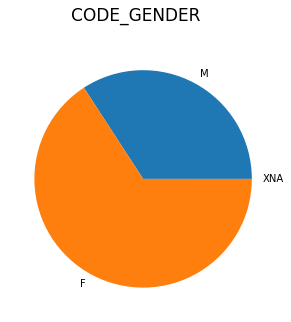

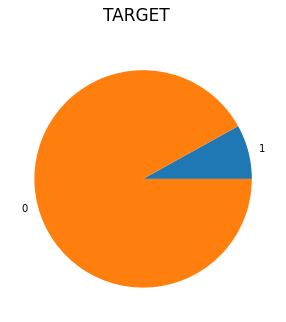

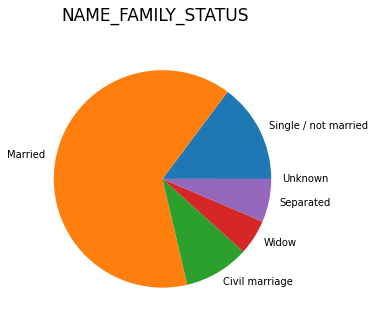

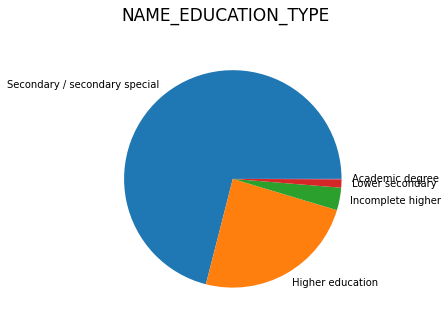

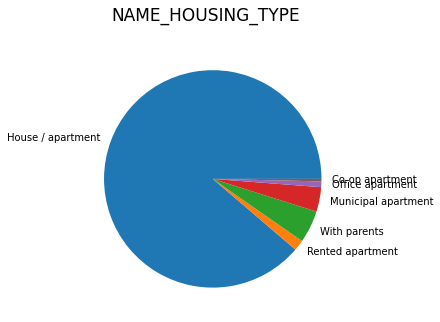

In [ ]:
##'OCCUPATION_TYPE', 
for i in ['CODE_GENDER', 'TARGET', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']:
  compte = []
  fig, ax = plt.subplots()
  fig.suptitle(i, fontsize=17)
  for j in data0[i].unique():
     compte.append(int(data0[i][data0[i] == j].value_counts()))
  ax.pie(compte, labels = data0[i].unique())
  plt.show()

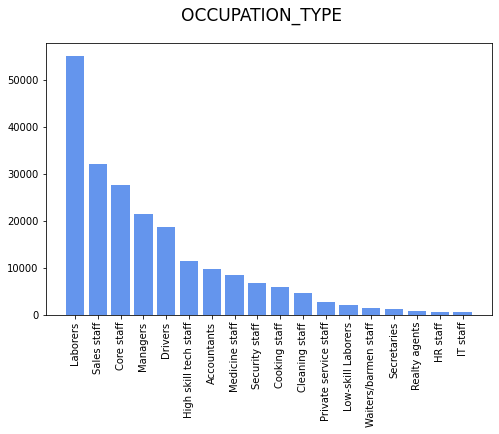

In [ ]:
nombre_vals = data0['OCCUPATION_TYPE'].value_counts()
plt.rcParams["figure.figsize"] = (8,5)
plt.bar(nombre_vals.index, nombre_vals.values, color=['cornflowerblue'])
plt.suptitle('OCCUPATION_TYPE', fontsize=17)
plt.xticks(rotation=90)  
plt.show()

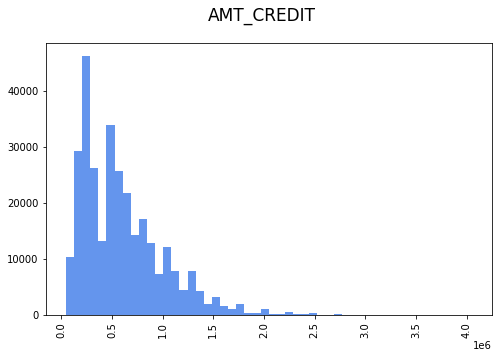

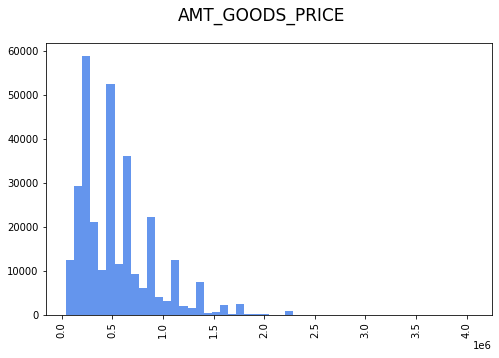

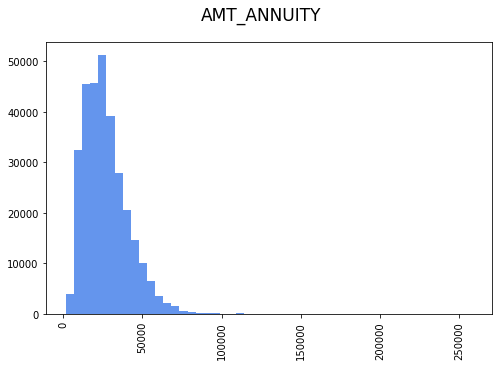

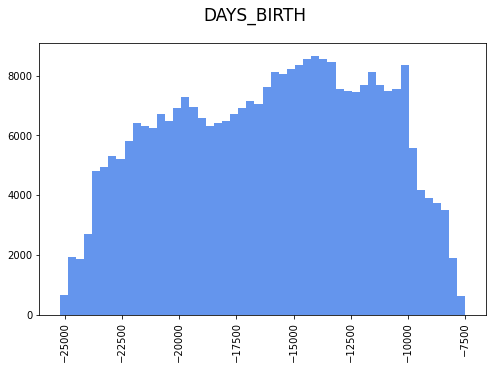

In [ ]:
for i in ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',  'DAYS_BIRTH']:
    plt.rcParams["figure.figsize"] = (8,5)
    plt.hist(data0[i], color=['cornflowerblue'], bins = 50)
    plt.suptitle(i, fontsize=17)
    plt.xticks(rotation=90)  
    plt.show()

# Preprocessing
Comme indiqué au début de cette feuille, ce preprocessing n'est pas de mon fait.

In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
# Read data and merge
data0 = pd.read_csv('application_train.csv')
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
data0 = data0[data0['CODE_GENDER'] != 'XNA']
    
docs = [_f for _f in data0.columns if 'FLAG_DOC' in _f]
live = [_f for _f in data0.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
data0['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

inc_by_org = data0[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

data0['NEW_CREDIT_TO_ANNUITY_RATIO'] = data0['AMT_CREDIT'] / data0['AMT_ANNUITY']
data0['NEW_CREDIT_TO_GOODS_RATIO'] = data0['AMT_CREDIT'] / data0['AMT_GOODS_PRICE']
data0['NEW_DOC_IND_KURT'] = data0[docs].kurtosis(axis=1)
data0['NEW_LIVE_IND_SUM'] = data0[live].sum(axis=1)
data0['NEW_INC_PER_CHLD'] = data0['AMT_INCOME_TOTAL'] / (1 + data0['CNT_CHILDREN'])
data0['NEW_INC_BY_ORG'] = data0['ORGANIZATION_TYPE'].map(inc_by_org)
data0['NEW_EMPLOY_TO_BIRTH_RATIO'] = data0['DAYS_EMPLOYED'] / data0['DAYS_BIRTH']
data0['NEW_ANNUITY_TO_INCOME_RATIO'] = data0['AMT_ANNUITY'] / (1 + data0['AMT_INCOME_TOTAL'])
data0['NEW_SOURCES_PROD'] = data0['EXT_SOURCE_1'] * data0['EXT_SOURCE_2'] * data0['EXT_SOURCE_3']
data0['NEW_EXT_SOURCES_SUM'] = data0[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)
data0['NEW_SCORES_STD'] = data0[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
data0['NEW_SCORES_STD'] = data0['NEW_SCORES_STD'].fillna(data0['NEW_SCORES_STD'].mean())
data0['NEW_CAR_TO_BIRTH_RATIO'] = data0['OWN_CAR_AGE'] / data0['DAYS_BIRTH']
data0['NEW_CAR_TO_EMPLOY_RATIO'] = data0['OWN_CAR_AGE'] / data0['DAYS_EMPLOYED']
data0['NEW_PHONE_TO_BIRTH_RATIO'] = data0['DAYS_LAST_PHONE_CHANGE'] / data0['DAYS_BIRTH']
data0['NEW_PHONE_TO_BIRTH_RATIO'] = data0['DAYS_LAST_PHONE_CHANGE'] / data0['DAYS_EMPLOYED']
data0['NEW_CREDIT_TO_INCOME_RATIO'] = data0['AMT_CREDIT'] / data0['AMT_INCOME_TOTAL']

In [ ]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    data0[bin_feature], uniques = pd.factorize(data0[bin_feature])
# Categorical features with One-Hot encode
data0, cat_cols = one_hot_encoder(data0, False)

In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')
bb, bb_cat = one_hot_encoder(bb, True)
bureau, bureau_cat = one_hot_encoder(bureau, True)
    
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
gc.collect()
    
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau
gc.collect()

0

In [ ]:
# Preprocess previous_applications.csv
prev = pd.read_csv('previous_application.csv')
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

0

In [ ]:
# Preprocess POS_CASH_balance.csv
pos = pd.read_csv('POS_CASH_balance.csv')
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

0

In [ ]:
# Preprocess installments_payments.csv
ins = pd.read_csv('installments_payments.csv')
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()

13

In [ ]:
# Preprocess credit_card_balance.csv
cc = pd.read_csv('credit_card_balance.csv')
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc
gc.collect()

0

In [ ]:
data1 = data0.join(bureau_agg, how='left', on='SK_ID_CURR')
data1 = data1.join(prev_agg, how='left', on='SK_ID_CURR')
data1 = data1.join(pos_agg, how='left', on='SK_ID_CURR')
data1 = data1.join(ins_agg, how='left', on='SK_ID_CURR')
data1 = data1.join(cc_agg, how='left', on='SK_ID_CURR')

In [ ]:
data1[np.isneginf(data1)] = 0

Je récupère les variables qui m'intéressent et j

In [ ]:
liste_features = [f for f in data1.columns if f not in ['TARGET',
                                                        'SK_ID_CURR',
                                                        'SK_ID_BUREAU',
                                                        'SK_ID_PREV',
                                                        'index',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MEAN',
                                                        'REFUSED_APP_CREDIT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_MAX',
                                                        'INSTAL_PAYMENT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_SUM'
                                                        ]]

In [ ]:
data2 = data1[liste_features].copy()
data2['TARGET'] = data1['TARGET'].copy()
data2 = data2.dropna(subset=['TARGET'])

In [ ]:
data2 = data2.dropna(subset=['TARGET'])

In [ ]:
data2.fillna(data2.mean(), inplace=True)

In [ ]:
train, test = model_selection.train_test_split(data2, test_size=0.5, random_state=2, stratify=data2['TARGET'])
trainy = train['TARGET']
testy = test['TARGET']

In [ ]:
scal = preprocessing.StandardScaler()
liste_features_stdscl = [sub + '_stdscl' for sub in liste_features]
for f in [liste_features]:
  m = train[f].mean()
  train[f].replace(np.inf, m, inplace=True)
  train[f].replace(-np.inf, m, inplace=True)
  train[f].replace(np.nan, m, inplace=True)
  test[f].replace(np.inf, m, inplace=True)
  test[f].replace(-np.inf, m, inplace=True)
  test[f].replace(np.nan, m, inplace=True)
feat_train = train[liste_features]
feat_test = test[liste_features]
scal.fit(feat_train)
feat_train = scal.transform(feat_train)
feat_test = scal.transform(feat_test)
trainX = pd.DataFrame(feat_train, index = trainy.index, columns = liste_features_stdscl)
testX = pd.DataFrame(feat_test, index = testy.index, columns = liste_features_stdscl)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
print('trainy: ', str(len(trainy)), ' individus.')
print('taux de positif', str(sum(trainy)/len(trainy)))

trainy:  153753  individus.
taux de positif 0.08072688012591624


J'exporte et je télécharge les données retravaillées.

In [ ]:
testX.to_csv('testX.csv')
files.download('testX.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainX.to_csv('trainX.csv')
files.download('trainX.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
testy.to_csv('testy.csv')
files.download('testy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainy.to_csv('trainy.csv')
files.download('trainy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>